In [1]:
import warnings
warnings.filterwarnings('ignore')
import os
os.environ['PROJ_LIB'] = r'C:/Users/mastr/miniconda3/pkgs/proj4-5.2.0-ha925a31_1/Library/share'     ## Windows OS
# os.environ['PROJ_LIB'] = r'/Users/mmastro/miniconda3/pkgs/proj4-5.2.0-ha925a31_1/Library/share'     ## Mac OS
import glob
import netCDF4 as nc
import numpy as np
import pandas as pd
import xarray as xr
#from scipy.signal import argrelextrema                      # Find local Maxima-Minima in numpy array
import matplotlib.colors as colors
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import cartopy.feature as cfeature
import cartopy as cart
import cartopy.crs as ccrs
import cartopy.mpl.ticker as cticker

Functions declaration

In [2]:
def detrend_dim(da, dim, degree):
    # detrend along a single dimension
    p = da.polyfit(dim=dim, deg=degree)
    fit = xr.polyval(da[dim], p.polyfit_coefficients)
    da_det = (da - fit)
    return da_det

def xr_mean_list(xr_list, esm):
    ## Function for calculate the mean response of several simulations from different ESM
    # xr_list: list of xarray, each representing one simulation 
    # nc_files: list of NetCDF opened with nc.Dataset(), containing data and attributes
    # returns an xr_list_new with one element for each esm 

    # List of ESM names in every simulation
    # esm = [a.source_id for a in nc_files]
    # esm = [nc_files]#

    # Assign as a new coordinate ESM name
    xr_list = [a.assign_coords(esm=b) for a,b in zip(xr_list,esm)]

    # List of unique ESM names sorted
    esm = list(set(esm))
    esm.sort()

    # Create a list of the different esm lists
    access = []; bcc = []; cesm = []; cmcc = []; cnrm = []; canesm = []; e3sm = []; ipsl = []; miroc = []; mpi = []; noresm = []; taiesm = []; ukesm = []
    esm_list = [access, bcc, cesm, cmcc, cnrm, canesm, e3sm, ipsl, miroc, mpi, noresm, taiesm, ukesm]

    # populate the esm_list according to xr.coords["esm"]
    for e,model in enumerate(esm):
        for i,xarray in enumerate(xr_list):
            esm_coord = xarray.coords["esm"]
            if esm_coord == esm[e]:
                esm_list[e].append(xarray)

    # take the mean of all the xarray belonging to the same esm
    xr_list_new = []
    for e in esm_list:
        content = xr.concat(e, dim='realiz')
        content1 = content.mean(dim = "realiz")
        xr_list_new.append(content1)
    
    return xr_list_new

## Fuction for subsetting colormap values ## 
def truncate_colormap(cmap, minval=0.0, maxval=1.0, n=100):
    new_cmap = colors.LinearSegmentedColormap.from_list(
        'trunc({n},{a:.2f},{b:.2f})'.format(n=cmap.name, a=minval, b=maxval),
        cmap(np.linspace(minval, maxval, n)))
    return new_cmap

## Function for creating a path, if needed ##
def checkDir(out_path):
    if not os.path.exists(out_path):
        os.makedirs(out_path)

def lag_linregress_3D(x, y, lagx=0, lagy=0):
    """
    Input: Two xr.Datarrays of any dimensions with the first dim being time. 
    Thus the input data could be a 1D time series, or for example, have three dimensions (time,lat,lon). 
    Datasets can be provied in any order, but note that the regression slope and intercept will be calculated
    for y with respect to x.
    Output: Covariance, correlation, regression slope and intercept, p-value, and standard error on regression
    between the two datasets along their aligned time dimension.  
    Lag values can be assigned to either of the data, with lagx shifting x, and lagy shifting y, with the specified lag amount. 
    """ 
    #1. Ensure that the data are properly alinged to each other. 
    x,y = xr.align(x,y)
    
    #2. Add lag information if any, and shift the data accordingly
    if lagx!=0:
        #If x lags y by 1, x must be shifted 1 step backwards. 
        #But as the 'zero-th' value is nonexistant, xr assigns it as invalid (nan). Hence it needs to be dropped
        x   = x.shift(time = -lagx).dropna(dim='time')
        #Next important step is to re-align the two datasets so that y adjusts to the changed coordinates of x
        x,y = xr.align(x,y)

    if lagy!=0:
        y   = y.shift(time = -lagy).dropna(dim='time')
        x,y = xr.align(x,y)
 
    #3. Compute data length, mean and standard deviation along time axis for further use: 
    n     = x.shape[0]
    xmean = x.mean(axis=0)
    ymean = y.mean(axis=0)
    xstd  = x.std(axis=0)
    ystd  = y.std(axis=0)
    
    #4. Compute covariance along time axis
    cov   =  np.sum((x - xmean)*(y - ymean), axis=0)/(n)
    
    #5. Compute correlation along time axis
    cor   = cov/(xstd*ystd)
    
    #6. Compute regression slope and intercept:
    slope     = cov/(xstd**2)
    intercept = ymean - xmean*slope
    y_pred =  intercept + slope*x
    res = y - y_pred

    #7. Compute P-value and standard error
    #Compute t-statistics
    tstats = cor*np.sqrt(n-2)/np.sqrt(1-cor**2)
    stderr = slope/tstats
    
    from scipy.stats import t
    pval   = t.sf(tstats, n-2)*2
    pval   = xr.DataArray(pval, dims=cor.dims, coords=cor.coords)

    #return cov,cor,slope,intercept,pval,stderr
    return res

def cor_3D(x, y, lagx=0, lagy=0):
    """
    Input: Two xr.Datarrays of any dimensions with the first dim being time. 
    Thus the input data could be a 1D time series, or for example, have three dimensions (time,lat,lon). 
    Datasets can be provied in any order, but note that the regression slope and intercept will be calculated
    for y with respect to x.
    Output: Covariance, correlation, regression slope and intercept, p-value, and standard error on regression
    between the two datasets along their aligned time dimension.  
    Lag values can be assigned to either of the data, with lagx shifting x, and lagy shifting y, with the specified lag amount. 
    """ 
    #1. Ensure that the data are properly alinged to each other. 
    x,y = xr.align(x,y)
    
    #2. Add lag information if any, and shift the data accordingly
    if lagx!=0:
        #If x lags y by 1, x must be shifted 1 step backwards. 
        #But as the 'zero-th' value is nonexistant, xr assigns it as invalid (nan). Hence it needs to be dropped
        x   = x.shift(time = -lagx).dropna(dim='time')
        #Next important step is to re-align the two datasets so that y adjusts to the changed coordinates of x
        x,y = xr.align(x,y)

    if lagy!=0:
        y   = y.shift(time = -lagy).dropna(dim='time')
        x,y = xr.align(x,y)
 
    #3. Compute data length, mean and standard deviation along time axis for further use: 
    n     = x.shape[0]
    xmean = x.mean(axis=0)
    ymean = y.mean(axis=0)
    xstd  = x.std(axis=0)
    ystd  = y.std(axis=0)
    
    #4. Compute covariance along time axis
    cov   =  np.sum((x - xmean)*(y - ymean), axis=0)/(n)
    
    #5. Compute correlation along time axis
    cor   = cov/(xstd*ystd)

    #return cov,cor,slope,intercept,pval,stderr
    return cor

def xr_multipletest(p, alpha=0.05, method='fdr_bh', **multipletests_kwargs):
    """Apply statsmodels.stats.multitest.multipletests for multi-dimensional xr.objects."""
    from statsmodels.stats.multitest import multipletests
    # stack all to 1d array
    p_stacked = p.stack(s=p.dims)
    # mask only where not nan: https://github.com/statsmodels/statsmodels/issues/2899
    mask = np.isfinite(p_stacked)
    pvals_corrected = np.full(p_stacked.shape, np.nan)
    reject = np.full(p_stacked.shape, np.nan)
    # apply test where mask
    reject[mask] = multipletests(
        p_stacked[mask], alpha=alpha, method=method, **multipletests_kwargs)[0]
    pvals_corrected[mask] = multipletests(
        p_stacked[mask], alpha=alpha, method=method, **multipletests_kwargs)[1]

    def unstack(reject, p_stacked):
        """Exchange values from p_stacked with reject (1d array) and unstack."""
        xreject = p_stacked.copy()
        xreject.values = reject
        xreject = xreject.unstack()
        return xreject

    reject = unstack(reject, p_stacked)
    pvals_corrected = unstack(pvals_corrected, p_stacked)
    return reject, pvals_corrected


In [3]:
# -- Path for the output files (images, etc)
# out_path = 'C:/Users/mastr/Documents/Amazon/RESULTS/'
out_path = 'G:/Shared drives/Amazon_ENSO_work/RESULTS/MLR/'

#out_path = "D:/Data/CMIP6/RESULTS"

# -- Create directories
checkDir(out_path)

### Open SST data

In [4]:
##### ------- Open data (MODEL) ------- #####
data_path = 'C:/Users/mastr/Documents/Amazon'
scenario = 'historical'
files = "nino34" + '_*_' + scenario + '_*'

files_list = []
for filepath in sorted(glob.glob(os.path.join(data_path+'/ENSO/detrended/'+files))):               # List of files sorted by name
        content = nc.Dataset(filepath)
        files_list.append(content)   

nino34_hist = []
for filepath in sorted(glob.glob(os.path.join(data_path+'/ENSO/detrended/'+files))):               # sorted is case sensitive                             ## List of files sorted by name
    content = xr.open_dataset(filepath, drop_variables=["time_bnds","lon_bnds","lat_bnds"]); #content = content.mean(dim="time")         ## values   var     dims    coords
    nino34_hist.append(content)

scenario = 'ssp585'
files = "nino34" + '_*_' + scenario + '_*' 

nino34_ssp = []
for filepath in sorted(glob.glob(os.path.join(data_path+'/ENSO/detrended/'+files))):               # sorted is case sensitive                             ## List of files sorted by name
    content = xr.open_dataset(filepath, drop_variables=["time_bnds","lon_bnds","lat_bnds"]); #content = content.mean(dim="time")         ## values   var     dims    coords
    nino34_ssp.append(content)

## Normalization
# for i,item in enumerate(nino34_hist):
#     nino34_hist[i] =  ((nino34_hist[i] - (nino34_hist[i].mean(dim='time'))).compute()/(nino34_hist[i].std(dim='time'))).compute()

# for i,item in enumerate(nino34_ssp):
#     nino34_ssp[i] =  ((nino34_ssp[i] - (nino34_ssp[i].mean(dim='time'))).compute()/(nino34_ssp[i].std(dim='time'))).compute()


## Resample from Monthly to seasonal timesteps
# nino34_hist = [a.resample(time="QS", label='left').mean() for a in nino34_hist]
# nino34_ssp = [a.resample(time="QS", label='left').mean() for a in nino34_ssp]

# Convert to dataarray
nino34_hist = [a.to_array() for a in nino34_hist]
nino34_ssp = [a.to_array() for a in nino34_ssp]

# Delete useless empty dimension
nino34_hist = [nino.squeeze().rename(variable = "tos").drop("tos") for nino in nino34_hist]
nino34_ssp = [nino.squeeze().rename(variable = "tos").drop("tos") for nino in nino34_ssp]

# Correct for spurious dimension
for i, item in enumerate(nino34_hist):
    if len(nino34_hist[i].shape)!=1:
        nino34_hist[i] = nino34_hist[i][1]
    else:
        None


### Open LAND data

In [31]:
data_path = 'E:/Data/analysis/'              

scenario = 'historical'
var_name = 'nep'
files = var_name + '_*_' + scenario + '_*' 

files_list = []
for filepath in sorted(glob.glob(os.path.join(data_path+'/'+scenario+'/'+files))):               # List of files sorted by name
        content = nc.Dataset(filepath)
        files_list.append(content)                                              # to retrieve netcdf original ATTRIBUTES

ds_hist_nep = []
for filepath in sorted(glob.glob(os.path.join(data_path+'/'+scenario+'/'+files))):                                       ## List of files sorted by name
    content = xr.open_dataarray(filepath, drop_variables=["time_bnds","lon_bnds","lat_bnds"])          ## values   var     dims    coords
    ds_hist_nep.append(content)

scenario = 'ssp585'
files = var_name + '_*_' + scenario + '_*' 

ds_ssp_nep = []
for filepath in sorted(glob.glob(os.path.join(data_path+'/'+scenario+'/'+files))):                                       ## List of files sorted by name
    content = xr.open_dataarray(filepath, drop_variables=["time_bnds","lon_bnds","lat_bnds"])           ## values   var     dims    coords
    ds_ssp_nep.append(content)    

# Subsetting latitude
ds_hist_nep = [a.sel(lat=slice(-30,30)) for a in ds_hist_nep]
ds_ssp_nep = [a.sel(lat=slice(-30,30)) for a in ds_ssp_nep]

# Uniform calendar
for i, item in enumerate(ds_hist_nep):
    if item['time'].dt.calendar == 'noleap' or item['time'].dt.calendar == '360_day':
        ds_hist_nep[i]['time'] = item.indexes['time'].to_datetimeindex()

for i, item in enumerate(ds_ssp_nep):
    if item['time'].dt.calendar == 'noleap' or item['time'].dt.calendar == '360_day':
        ds_ssp_nep[i]['time'] = item.indexes['time'].to_datetimeindex()

# Select time periods
ds_hist_nep = [a.sel(time = slice("1901-01", "1960-12")) for a in ds_hist_nep]
ds_ssp_nep = [a.sel(time = slice("2041-01", "2100-12")) for a in ds_ssp_nep]

# Detrending of 1st order
ds_hist_nep = [detrend_dim(a.sel(time = slice("1901-01", "1960-12")), "time", 1) for a in ds_hist_nep]
ds_ssp_nep = [detrend_dim(a, "time", 1) for a in ds_ssp_nep]

# Resample from months to seasons
# ds_hist_nep = [a.resample(time="QS", label='left').mean() for a in ds_hist_nep]
# ds_ssp_nep = [a.resample(time="QS", label='left').mean() for a in ds_ssp_nep]

# CanESM5 hist and ssp have numerical values of ocean equal to 
# hist: -9.304011e-07
# ssp: -1.120609e-05

for i, item in enumerate(files_list):
    if files_list[i].source_id == "CanESM5":
        ds_hist_nep[i] = ds_hist_nep[i].where(ds_hist_nep[i] != -3.7270379e-07)
        ds_ssp_nep[i] = ds_ssp_nep[i].where(ds_ssp_nep[i] != -6.18386321e-06)

In [32]:
# Correct for inverse NEP value in CESM2

esm = []
for filepath in sorted(glob.glob(os.path.join('E:/Data/analysis/'+'/'+'historical'+'/'+'nep' + '_*_' + 'historical' + '_*'))):     
        content = nc.Dataset(filepath).source_id
        esm.append(content)   

for i,model in enumerate(esm):
        if model == "CESM2-WACCM":
                ds_hist_nep[i] = ds_hist_nep[i]*-1
                ds_ssp_nep[i] = ds_ssp_nep[i]*-1
        else:
                None

In [7]:
data_path = 'E:/Data/analysis/'              

scenario = 'historical'
var_name = 'pr'
files = var_name + '_*_' + scenario + '_*' 

ds_hist_pr = []
for filepath in sorted(glob.glob(os.path.join(data_path+'/'+scenario+'/'+files))):                                       ## List of files sorted by name
    content = xr.open_dataarray(filepath, drop_variables=["time_bnds","lon_bnds","lat_bnds"])          ## values   var     dims    coords
    ds_hist_pr.append(content)

scenario = 'ssp585'
files = var_name + '_*_' + scenario + '_*' 

ds_ssp_pr = []
for filepath in sorted(glob.glob(os.path.join(data_path+'/'+scenario+'/'+files))):                                       ## List of files sorted by name
    content = xr.open_dataarray(filepath, drop_variables=["time_bnds","lon_bnds","lat_bnds"])           ## values   var     dims    coords
    ds_ssp_pr.append(content)    

# Uniform calendar
for i, item in enumerate(ds_hist_pr):
    if item['time'].dt.calendar == 'noleap' or item['time'].dt.calendar == '360_day':
        ds_hist_pr[i]['time'] = item.indexes['time'].to_datetimeindex()

for i, item in enumerate(ds_ssp_pr):
    if item['time'].dt.calendar == 'noleap' or item['time'].dt.calendar == '360_day':
        ds_ssp_pr[i]['time'] = item.indexes['time'].to_datetimeindex()

# Subsetting latitude
ds_hist_pr = [a.sel(lat=slice(-30,30)) for a in ds_hist_pr]
ds_ssp_pr = [a.sel(lat=slice(-30,30)) for a in ds_ssp_pr]

# Correct pr ssp585 UKESM-r4 from lon:192 to lon:191
ds_ssp_pr[41] = ds_ssp_pr[41].isel(lon = slice(0,191))
# Correct pr hist UKESM-r4 from lon:192 to lon:191
ds_hist_pr[42] = ds_hist_pr[42].isel(lon = slice(0,191))

# Select time periods
ds_hist_pr = [a.sel(time = slice("1901-01", "1960-12")) for a in ds_hist_pr]
ds_ssp_pr = [a.sel(time = slice("2041-01", "2100-12")) for a in ds_ssp_pr]

# Detrending of 1st order
ds_hist_pr = [detrend_dim(a, "time", 1) for a in ds_hist_pr]
ds_ssp_pr = [detrend_dim(a, "time", 1) for a in ds_ssp_pr]

# Resample from months to seasons
# ds_hist_pr = [a.resample(time="QS", label='left').mean() for a in ds_hist_pr]
# ds_ssp_pr = [a.resample(time="QS", label='left').mean() for a in ds_ssp_pr]

# CanESM5 hist and ssp have numerical values of ocean equal to 
# hist: -9.304011e-07
# ssp: -1.120609e-05

for i, item in enumerate(files_list):
    if files_list[i].source_id == "CanESM5":
        ds_hist_pr[i] = ds_hist_pr[i].where(ds_hist_pr[i] != -3.7270379e-07)
        ds_ssp_pr[i] = ds_ssp_pr[i].where(ds_ssp_pr[i] != -6.18386321e-06)

In [8]:
data_path = 'E:/Data/analysis/'              

scenario = 'historical'
var_name = 'tas'
files = var_name + '_*_' + scenario + '_*' 

ds_hist_tas = []
for filepath in sorted(glob.glob(os.path.join(data_path+'/'+scenario+'/'+files))):                                       ## List of files sorted by name
    content = xr.open_dataarray(filepath, drop_variables=["time_bnds","lon_bnds","lat_bnds"])          ## values   var     dims    coords
    ds_hist_tas.append(content)

scenario = 'ssp585'
files = var_name + '_*_' + scenario + '_*' 

ds_ssp_tas = []
for filepath in sorted(glob.glob(os.path.join(data_path+'/'+scenario+'/'+files))):                                       ## List of files sorted by name
    content = xr.open_dataarray(filepath, drop_variables=["time_bnds","lon_bnds","lat_bnds"])           ## values   var     dims    coords
    ds_ssp_tas.append(content)    

# Uniform calendar
for i, item in enumerate(ds_hist_tas):
    if item['time'].dt.calendar == 'noleap' or item['time'].dt.calendar == '360_day':
        ds_hist_tas[i]['time'] = item.indexes['time'].to_datetimeindex()

for i, item in enumerate(ds_ssp_tas):
    if item['time'].dt.calendar == 'noleap' or item['time'].dt.calendar == '360_day':
        ds_ssp_tas[i]['time'] = item.indexes['time'].to_datetimeindex()

# Subsetting latitude
ds_hist_tas = [a.sel(lat=slice(-30,30)) for a in ds_hist_tas]
ds_ssp_tas = [a.sel(lat=slice(-30,30)) for a in ds_ssp_tas]

# Select time periods
ds_hist_tas = [a.sel(time = slice("1901-01", "1960-12")) for a in ds_hist_tas]
ds_ssp_tas = [a.sel(time = slice("2041-01", "2100-12")) for a in ds_ssp_tas]

# Detrending of 1st order
ds_hist_tas = [detrend_dim(a, "time", 1) for a in ds_hist_tas]
ds_ssp_tas = [detrend_dim(a, "time", 1) for a in ds_ssp_tas]

# Resample from months to seasons
# ds_hist_tas = [a.resample(time="QS", label='left').mean() for a in ds_hist_tas]
# ds_ssp_tas = [a.resample(time="QS", label='left').mean() for a in ds_ssp_tas]

# CanESM5 hist and ssp have numerical values of ocean equal to 
# hist: -9.304011e-07
# ssp: -1.120609e-05

for i, item in enumerate(files_list):
    if files_list[i].source_id == "CanESM5":
        ds_hist_tas[i] = ds_hist_tas[i].where(ds_hist_tas[i] != -3.7270379e-07)
        ds_ssp_tas[i] = ds_ssp_tas[i].where(ds_ssp_tas[i] != -6.18386321e-06)

In [9]:
# data_path = 'E:/Data/analysis/'              

# scenario = 'historical'
# var_name = 'mrso'
# files = var_name + '_*_' + scenario + '_*' 

# ds_hist_mrso = []
# for filepath in sorted(glob.glob(os.path.join(data_path+'/'+scenario+'/'+files))):                                       ## List of files sorted by name
#     content = xr.open_dataarray(filepath, drop_variables=["time_bnds","lon_bnds","lat_bnds"])          ## values   var     dims    coords
#     ds_hist_mrso.append(content)

# scenario = 'ssp585'
# files = var_name + '_*_' + scenario + '_*' 

# ds_ssp_mrso = []
# for filepath in sorted(glob.glob(os.path.join(data_path+'/'+scenario+'/'+files))):                                       ## List of files sorted by name
#     content = xr.open_dataarray(filepath, drop_variables=["time_bnds","lon_bnds","lat_bnds"])           ## values   var     dims    coords
#     ds_ssp_mrso.append(content)    

# # Subsetting latitude
# ds_hist_mrso = [a.sel(lat=slice(-30,30)) for a in ds_hist_mrso]
# ds_ssp_mrso = [a.sel(lat=slice(-30,30)) for a in ds_ssp_mrso]

# # Uniform calendar
# for i, item in enumerate(ds_hist_mrso):
#     if item['time'].dt.calendar == 'noleap' or item['time'].dt.calendar == '360_day':
#         ds_hist_mrso[i]['time'] = item.indexes['time'].to_datetimeindex()

# for i, item in enumerate(ds_ssp_mrso):
#     if item['time'].dt.calendar == 'noleap' or item['time'].dt.calendar == '360_day':
#         ds_ssp_mrso[i]['time'] = item.indexes['time'].to_datetimeindex()

# # Select time periods
# ds_hist_mrso = [a.sel(time = slice("1901-01", "1960-12")) for a in ds_hist_mrso]
# ds_ssp_mrso = [a.sel(time = slice("2041-01", "2100-12")) for a in ds_ssp_mrso]

# # Detrending of 1st order
# ds_hist_mrso = [detrend_dim(a, "time", 1) for a in ds_hist_mrso]
# ds_ssp_mrso = [detrend_dim(a, "time", 1) for a in ds_ssp_mrso]

# # Resample from months to seasons
# ds_hist_mrso = [a.resample(time="QS", label='left').mean() for a in ds_hist_mrso]
# ds_ssp_mrso = [a.resample(time="QS", label='left').mean() for a in ds_ssp_mrso]


In [10]:
data_path = 'E:/Data/analysis/'              

scenario = 'historical'
var_name = 'rsds'
files = var_name + '_*_' + scenario + '_*' 

ds_hist_rsds = []
for filepath in sorted(glob.glob(os.path.join(data_path+'/'+scenario+'/'+files))):                                       ## List of files sorted by name
    content = xr.open_dataarray(filepath, drop_variables=["time_bnds","lon_bnds","lat_bnds"])          ## values   var     dims    coords
    ds_hist_rsds.append(content)

scenario = 'ssp585'
files = var_name + '_*_' + scenario + '_*' 

ds_ssp_rsds = []
for filepath in sorted(glob.glob(os.path.join(data_path+'/'+scenario+'/'+files))):                                       ## List of files sorted by name
    content = xr.open_dataarray(filepath, drop_variables=["time_bnds","lon_bnds","lat_bnds"])           ## values   var     dims    coords
    ds_ssp_rsds.append(content)    

# Subsetting latitude
ds_hist_rsds = [a.sel(lat=slice(-30,30)) for a in ds_hist_rsds]
ds_ssp_rsds = [a.sel(lat=slice(-30,30)) for a in ds_ssp_rsds]

# Uniform calendar
for i, item in enumerate(ds_hist_rsds):
    if item['time'].dt.calendar == 'noleap' or item['time'].dt.calendar == '360_day':
        ds_hist_rsds[i]['time'] = item.indexes['time'].to_datetimeindex()

for i, item in enumerate(ds_ssp_rsds):
    if item['time'].dt.calendar == 'noleap' or item['time'].dt.calendar == '360_day':
        ds_ssp_rsds[i]['time'] = item.indexes['time'].to_datetimeindex()

# Select time periods
ds_hist_rsds = [a.sel(time = slice("1901-01", "1960-12")) for a in ds_hist_rsds]
ds_ssp_rsds = [a.sel(time = slice("2041-01", "2100-12")) for a in ds_ssp_rsds]

# Detrending of 1st order
ds_hist_rsds = [detrend_dim(a, "time", 1) for a in ds_hist_rsds]
ds_ssp_rsds = [detrend_dim(a, "time", 1) for a in ds_ssp_rsds]

# Resample from months to seasons
ds_hist_rsds = [a.resample(time="QS", label='left').mean() for a in ds_hist_rsds]
ds_ssp_rsds = [a.resample(time="QS", label='left').mean() for a in ds_ssp_rsds]


In [11]:
data_path = 'E:/Data/analysis/'              

scenario = 'historical'
var_name = 'hfls'
files = var_name + '_*_' + scenario + '_*' 

ds_hist_hfls = []
for filepath in sorted(glob.glob(os.path.join(data_path+'/'+scenario+'/'+files))):                                       ## List of files sorted by name
    content = xr.open_dataarray(filepath, drop_variables=["time_bnds","lon_bnds","lat_bnds"])          ## values   var     dims    coords
    ds_hist_hfls.append(content)

scenario = 'ssp585'
files = var_name + '_*_' + scenario + '_*' 

ds_ssp_hfls = []
for filepath in sorted(glob.glob(os.path.join(data_path+'/'+scenario+'/'+files))):                                       ## List of files sorted by name
    content = xr.open_dataarray(filepath, drop_variables=["time_bnds","lon_bnds","lat_bnds"])           ## values   var     dims    coords
    ds_ssp_hfls.append(content)    

# Subsetting latitude
ds_hist_hfls = [a.sel(lat=slice(-30,30)) for a in ds_hist_hfls]
ds_ssp_hfls = [a.sel(lat=slice(-30,30)) for a in ds_ssp_hfls]

# Uniform calendar
for i, item in enumerate(ds_hist_hfls):
    if item['time'].dt.calendar == 'noleap' or item['time'].dt.calendar == '360_day':
        ds_hist_hfls[i]['time'] = item.indexes['time'].to_datetimeindex()

for i, item in enumerate(ds_ssp_hfls):
    if item['time'].dt.calendar == 'noleap' or item['time'].dt.calendar == '360_day':
        ds_ssp_hfls[i]['time'] = item.indexes['time'].to_datetimeindex()

# Select time periods
ds_hist_hfls = [a.sel(time = slice("1901-01", "1960-12")) for a in ds_hist_hfls]
ds_ssp_hfls = [a.sel(time = slice("2041-01", "2100-12")) for a in ds_ssp_hfls]

# Detrending of 1st order
ds_hist_hfls = [detrend_dim(a, "time", 1) for a in ds_hist_hfls]
ds_ssp_hfls = [detrend_dim(a, "time", 1) for a in ds_ssp_hfls]

# Resample from months to seasons
ds_hist_hfls = [a.resample(time="QS", label='left').mean() for a in ds_hist_hfls]
ds_ssp_hfls = [a.resample(time="QS", label='left').mean() for a in ds_ssp_hfls]


### Correct for lon lat mishape and values

In [38]:
# Correct the number of longitude points
ds_hist_nep = [a.isel(lon = slice(0,b.lon.shape[0])) for a,b in zip(ds_hist_nep, ds_hist_pr)]
# ds_hist_mrso = [a.isel(lon = slice(0,b.lon.shape[0])) for a,b in zip(ds_hist_mrso, ds_hist_pr)]
# ds_hist_tas = [a.isel(lon = slice(0,b.lon.shape[0])) for a,b in zip(ds_hist_tas, ds_hist_pr)]
# ds_hist_rsds = [a.isel(lon = slice(0,b.lon.shape[0])) for a,b in zip(ds_hist_rsds, ds_hist_pr)]
# ds_hist_hfls = [a.isel(lon = slice(0,b.lon.shape[0])) for a,b in zip(ds_hist_hfls, ds_hist_pr)]
# ds_ssp_hfls = [a.isel(lon = slice(0,b.lon.shape[0])) for a,b in zip(ds_ssp_hfls, ds_ssp_pr)]
# ds_ssp_rsds = [a.isel(lon = slice(0,b.lon.shape[0])) for a,b in zip(ds_ssp_rsds, ds_ssp_pr)]
ds_ssp_nep = [a.isel(lon = slice(0,b.lon.shape[0])) for a,b in zip(ds_ssp_nep, ds_ssp_pr)]
# ds_ssp_mrso = [a.isel(lon = slice(0,b.lon.shape[0])) for a,b in zip(ds_ssp_mrso, ds_ssp_pr)]
# ds_ssp_tas = [a.isel(lon = slice(0,b.lon.shape[0])) for a,b in zip(ds_ssp_tas, ds_ssp_pr)]

# Assign the exactly same set of coordinates to ALL the dataarray (avoid duplication due to numerical approximation of lon lat)
ds_hist_pr = [a.assign_coords(lat = b.lat, lon = b.lon) for a,b in zip(ds_hist_pr,ds_hist_nep)]
# ds_hist_tas = [a.assign_coords(lat = b.lat, lon = b.lon) for a,b in zip(ds_hist_tas,ds_hist_nep)]
# ds_hist_mrso = [a.assign_coords(lat = b.lat, lon = b.lon) for a,b in zip(ds_hist_mrso,ds_hist_nep)]
# ds_hist_rsds = [a.assign_coords(lat = b.lat, lon = b.lon) for a,b in zip(ds_hist_rsds,ds_hist_nep)]
# ds_hist_hfls = [a.assign_coords(lat = b.lat, lon = b.lon) for a,b in zip(ds_hist_hfls,ds_hist_nep)]
# ds_ssp_hfls = [a.assign_coords(lat = b.lat, lon = b.lon) for a,b in zip(ds_ssp_hfls,ds_ssp_nep)]
# ds_ssp_rsds = [a.assign_coords(lat = b.lat, lon = b.lon) for a,b in zip(ds_ssp_rsds,ds_ssp_nep)]
ds_ssp_pr = [a.assign_coords(lat = b.lat, lon = b.lon) for a,b in zip(ds_ssp_pr,ds_ssp_nep)]
# ds_ssp_tas = [a.assign_coords(lat = b.lat, lon = b.lon) for a,b in zip(ds_ssp_tas,ds_ssp_nep)]
# ds_ssp_mrso = [a.assign_coords(lat = b.lat, lon = b.lon) for a,b in zip(ds_ssp_mrso,ds_ssp_nep)]


### Remove seasonality

In [42]:
# Remove seasonal cycle by subtracting the monthly climatological mean

ds_hist_nep = [a.groupby("time.month") - a.groupby("time.month").mean("time") for a in ds_hist_nep]
# ds_hist_mrso = [a.groupby("time.month") - a.groupby("time.month").mean("time") for a in ds_hist_mrso]
# ds_hist_tas = [a.groupby("time.month") - a.groupby("time.month").mean("time") for a in ds_hist_tas]
# ds_hist_rsds = [a.groupby("time.month") - a.groupby("time.month").mean("time") for a in ds_hist_rsds]
# ds_hist_hfls = [a.groupby("time.month") - a.groupby("time.month").mean("time") for a in ds_hist_hfls]
# ds_ssp_hfls = [a.groupby("time.month") - a.groupby("time.month").mean("time") for a in ds_ssp_hfls]
# ds_ssp_rsds = [a.groupby("time.month") - a.groupby("time.month").mean("time") for a in ds_ssp_rsds]
ds_ssp_nep = [a.groupby("time.month") - a.groupby("time.month").mean("time") for a in ds_ssp_nep]
# ds_ssp_mrso = [a.groupby("time.month") - a.groupby("time.month").mean("time") for a in ds_ssp_mrso]
# ds_ssp_tas = [a.groupby("time.month") - a.groupby("time.month").mean("time") for a in ds_ssp_tas]


### Teleconnection Lag test 1 

- Testing the correlation-regression coefficient of 1 to 6 months lag effect
- Monthly time series of nino3.4 and NEP

In [140]:
def lag_regress(x, y, lagx=0, lagy=0):
    """
    Input: Two xr.Datarrays of any dimensions with the first dim being time. 
    Thus the input data could be a 1D time series, or for example, have three dimensions (time,lat,lon). 
    Datasets can be provied in any order, but note that the regression slope and intercept will be calculated
    for y with respect to x.
    Output: Covariance, correlation, regression slope and intercept, p-value, and standard error on regression
    between the two datasets along their aligned time dimension.  
    Lag values can be assigned to either of the data, with lagx shifting x, and lagy shifting y, with the specified lag amount. 
    """ 
    #1. Ensure that the data are properly alinged to each other. 
    x,y = xr.align(x,y)
    
    #2. Add lag information if any, and shift the data accordingly
    if lagx!=0:
        #If x lags y by 1, x must be shifted 1 step backwards. 
        #But as the 'zero-th' value is nonexistant, xr assigns it as invalid (nan). Hence it needs to be dropped
        x   = x.shift(time = -lagx).dropna(dim='time')
        #Next important step is to re-align the two datasets so that y adjusts to the changed coordinates of x
        x,y = xr.align(x,y)

    if lagy!=0:
        y   = y.shift(time = -lagy).dropna(dim='time')
        x,y = xr.align(x,y)
 
    #3. Compute data length, mean and standard deviation along time axis for further use: 
    n     = x.shape[0]
    xmean = x.mean(axis=0)
    ymean = y.mean(axis=0)
    xstd  = x.std(axis=0)
    ystd  = y.std(axis=0)
    
    #4. Compute covariance along time axis
    cov   =  np.sum((x - xmean)*(y - ymean), axis=0)/(n)
    
    #5. Compute correlation along time axis
    cor   = cov/(xstd*ystd)
    
    #6. Compute regression slope and intercept:
    slope     = cov/(xstd**2)
    intercept = ymean - xmean*slope
    y_pred =  intercept + slope*x
    res = y - y_pred

    #7. Compute P-value and standard error
    #Compute t-statistics
    tstats = cor*np.sqrt(n-2)/np.sqrt(1-cor**2)
    stderr = slope/tstats
    
    from scipy.stats import t
    pval   = t.sf(tstats, n-2)*2
    pval   = xr.DataArray(pval, dims=cor.dims, coords=cor.coords)

    #return cov,cor,slope,intercept,pval,stderr
    return slope

coef_hist = []
for i, item in enumerate(ds_hist_nep):
    X = nino34_hist[i]/nino34_hist[i].std(dim = "time")
    Y = ds_hist_nep[i].sel(lon= slice(260,340))/ds_hist_nep[i].sel(lon= slice(260,340)).std(dim = "time")
    nolag = lag_regress(X,Y, lagx = 0).rename("nolag")
    lag1 = lag_regress(X,Y,lagx = 1).rename("lag1")
    lag2 = lag_regress(X,Y,lagx = 2).rename("lag2")
    lag3 = lag_regress(X,Y,lagx = 3).rename("lag3")
    lag4 = lag_regress(X,Y,lagx = 4).rename("lag4")
    lag5 = lag_regress(X,Y,lagx = 5).rename("lag5")
    lag6 = lag_regress(X,Y,lagx = 6).rename("lag6")
    lag7 = lag_regress(X,Y,lagx = 7).rename("lag7")
    lag8 = lag_regress(X,Y,lagx = 8).rename("lag8")
    lag9 = lag_regress(X,Y,lagx = 9).rename("lag9")
    coef = xr.concat([nolag, lag1, lag2, lag3, lag4, lag5, lag6, lag7, lag8, lag9], dim = "coefficients")
    coef_hist.append(coef)

coef_ssp = []
for i, item in enumerate(ds_ssp_nep):
    X = nino34_ssp[i]/nino34_ssp[i].std(dim = "time")
    Y = ds_ssp_nep[i].sel(lon= slice(260,340))/ds_ssp_nep[i].sel(lon= slice(260,340)).std(dim = "time")
    nolag = lag_regress(X,Y, lagx = 0).rename("nolag")
    lag1 = lag_regress(X,Y,lagx = 1).rename("lag1")
    lag2 = lag_regress(X,Y,lagx = 2).rename("lag2")
    lag3 = lag_regress(X,Y,lagx = 3).rename("lag3")
    lag4 = lag_regress(X,Y,lagx = 4).rename("lag4")
    lag5 = lag_regress(X,Y,lagx = 5).rename("lag5")
    lag6 = lag_regress(X,Y,lagx = 6).rename("lag6")
    lag7 = lag_regress(X,Y,lagx = 7).rename("lag7")
    lag8 = lag_regress(X,Y,lagx = 8).rename("lag8")
    lag9 = lag_regress(X,Y,lagx = 9).rename("lag9")
    coef = xr.concat([nolag, lag1, lag2, lag3, lag4, lag5, lag6, lag7, lag8, lag9], dim = "coefficients")
    coef_ssp.append(coef)


In [21]:
# Zonal mean of REAN and ESM

import json
import os
import glob
import geopandas as gpd
from importlib.machinery import SourceFileLoader
# imports the module from the given path
gpd = SourceFileLoader("geopandas","C:/Users/mastr/miniconda3/pkgs/geopandas-0.7.0-py_1/site-packages/geopandas/__init__.py").load_module()
import regionmask

def cell_weight(ds):
    R = 6.371e6
    dϕ = np.deg2rad(ds.lat[1] - ds.lat[0])
    dλ = np.deg2rad(ds.lon[1] - ds.lon[0])
    dlat = R * dϕ * xr.ones_like(ds.lon)
    dlon = R * dλ * np.cos(np.deg2rad(ds.lat))
    cell_area = dlon * dlat
    return(cell_area)

def mask_shape(ds,gdf):
    # Create mask of multiple regions from shapefile
    mask = regionmask.mask_3D_geopandas(
            gdf,
            ds.lon,
            ds.lat,
            drop=True
        )
    ds_m = ds.where(mask)
    return ds_m

def zonal_stat(ds,gdf):
    # Create mask of multiple regions from shapefile
    mask = regionmask.mask_3D_geopandas(
            gdf,
            ds.lon,
            ds.lat,
            drop=True
        )
    # Apply mask to xarray
    ds_m = ds.where(mask)
    # Calculate cell area of the xarray
    cell_area = cell_weight(ds)
    # Zonal statistic for all the regions
    ds_z = ds_m.weighted(cell_area).mean(["lat","lon"])
    # ds_z = ds_z.groupby("region").mean()
    return ds_z

# geodf = gpd.read_file((os.path.join('C:/Users/mastr/Documents/Amazon/amazon_border/biome.shp')))
geodf = gpd.read_file((os.path.join('C:/Users/mastr/Documents/Amazon/hybas_sa_lev01-12_v1c/hybas_sa_lev02_v1c.shp')))

In [141]:
# Zonal Mean in Amazon basin 
# Need to convert "object" type to "float64"

coef_hist_amz = [zonal_stat(a.astype("float64"), geodf).sel(region = 1) for a in coef_hist]
coef_ssp_amz = [zonal_stat(a.astype("float64"), geodf).sel(region = 1) for a in coef_ssp]

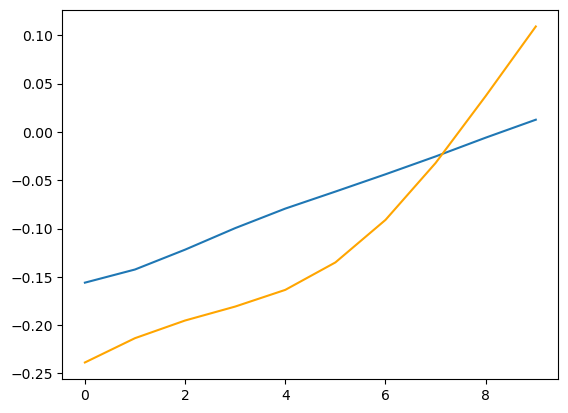

In [142]:
plt.plot(coef_hist_amz[0])
plt.plot(coef_ssp_amz[0], color = "orange")

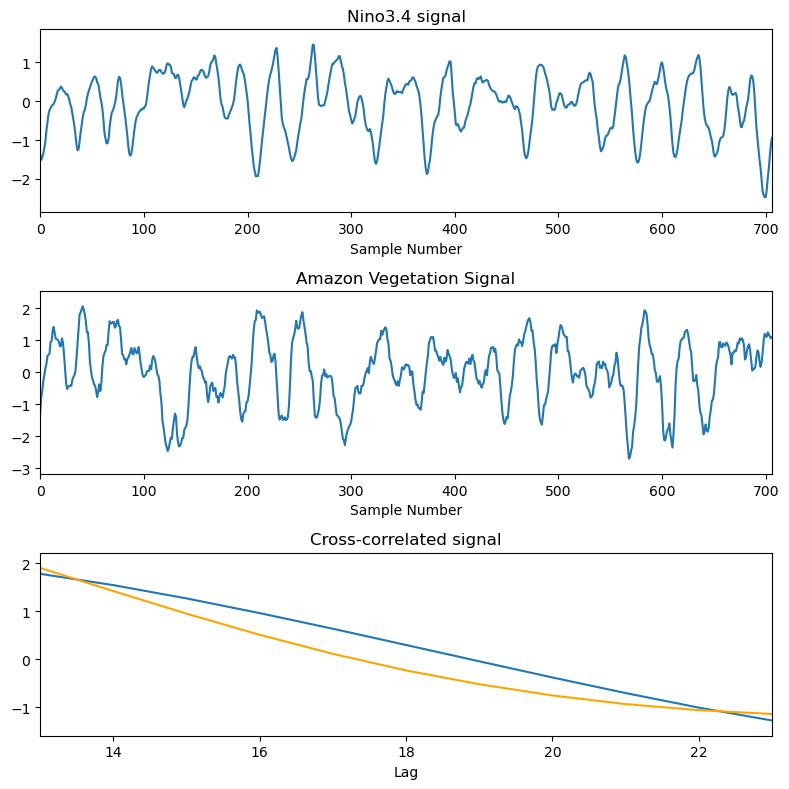

In [126]:
from scipy import signal

# HIST Cross-Correlation
sig_nino = nino34_hist[0].sel(time = slice("1901-01", "1960-12"))[11:-2]
sig = zonal_stat(ds_hist_nep[0], geodf).sel(region = 1).rolling(time = 12).mean()[11:-2]
sig = sig/sig.std(dim= "time")
corr = signal.correlate(sig_nino, sig)
lags = signal.correlation_lags(len(sig), len(sig_nino))

# SSP Cross-Correlation
sig_nino_ssp = nino34_ssp[0].sel(time = slice("2041-01", "2100-12"))[11:-2]
sig_ssp = zonal_stat(ds_ssp_nep[0], geodf).sel(region = 1).rolling(time = 12).mean()[11:-2]
sig_ssp = sig_ssp/sig_ssp.std(dim= "time")
corr_ssp = signal.correlate(sig_nino_ssp, sig_ssp)
lags_ssp = signal.correlation_lags(len(sig_ssp), len(sig_nino_ssp))

corr /= np.max(corr)

fig, (ax_nino, ax_amz, ax_corr) = plt.subplots(3, 1, figsize=(8,8))

ax_nino.plot(sig_nino)

ax_nino.set_title('Nino3.4 signal')

ax_nino.set_xlabel('Sample Number')

ax_amz.plot(sig)

ax_amz.set_title('Amazon Vegetation Signal')

ax_amz.set_xlabel('Sample Number')

ax_corr.plot(lags[719:730], corr[719:730]/corr[719:730].std())
ax_corr.plot(lags_ssp[719:730], corr_ssp[719:730]/corr_ssp[719:730].std(), color = "orange")

ax_corr.set_title('Cross-correlated signal')

ax_corr.set_xlabel('Lag')

ax_nino.margins(0, 0.1)

ax_amz.margins(0, 0.1)

ax_corr.margins(0, 0.1)

fig.tight_layout()

plt.show()

### Teleconnection Lag test 2

- Testing the correlation-regression coefficient of rolling 3 months mean effect
- Nino3.4 using DJF and NEP using 3 months rolling mean (DJF, JFM, FMA...)

In [44]:
# Resample from Monthly to seasonal timesteps
nino34_hist_djf = [a.resample(time="QS", label='left').mean() for a in nino34_hist]
nino34_ssp_djf = [a.resample(time="QS", label='left').mean() for a in nino34_ssp]

nino34_hist_djf = [a.sel(time = a.time.dt.season=="DJF").sel(time = slice("1901-01", "1960-12")) for a in nino34_hist_djf]
nino34_ssp_djf = [a.sel(time = a.time.dt.season=="DJF").sel(time = slice("2041-01", "2100-12")) for a in nino34_ssp_djf]

In [45]:
# Select rolling seasons

ds_hist_nep_lag = []
for i, item in enumerate(ds_hist_nep):
    content = item.rolling(time = 3).mean()                # Compute 3 months running mean
    months = np.arange(2,9)
    lags = []
    for m in months:
        shift = content[content.time.dt.month == m].rename(f"{str}{m}").assign_coords(time = nino34_hist_djf[i].time)     # Select March to get the average over DJF
        lags.append(shift)
    lag = xr.concat(lags, dim = "lags")#.assign_coords(time = nino34_hist_djf[i].time)
    ds_hist_nep_lag.append(lag)

ds_ssp_nep_lag = []
for i, item in enumerate(ds_ssp_nep):
    content = item.rolling(time = 3).mean()                # Compute 3 months running mean
    months = np.arange(2,9)
    lags = []
    for m in months:
        shift = content[content.time.dt.month == m].rename(f"{str}{m}").assign_coords(time = nino34_ssp_djf[i].time)     # Select March to get the average over DJF
        lags.append(shift)
    lag = xr.concat(lags, dim = "lags")#.assign_coords(time = nino34_ssp_djf[i].time)
    ds_ssp_nep_lag.append(lag)


In [46]:
def lag_regress(x, y, lagx=0, lagy=0):
    """
    Input: Two xr.Datarrays of any dimensions with the first dim being time. 
    Thus the input data could be a 1D time series, or for example, have three dimensions (time,lat,lon). 
    Datasets can be provied in any order, but note that the regression slope and intercept will be calculated
    for y with respect to x.
    Output: Covariance, correlation, regression slope and intercept, p-value, and standard error on regression
    between the two datasets along their aligned time dimension.  
    Lag values can be assigned to either of the data, with lagx shifting x, and lagy shifting y, with the specified lag amount. 
    """ 
    #1. Ensure that the data are properly alinged to each other. 
    x,y = xr.align(x,y)
    
    #2. Add lag information if any, and shift the data accordingly
    if lagx!=0:
        #If x lags y by 1, x must be shifted 1 step backwards. 
        #But as the 'zero-th' value is nonexistant, xr assigns it as invalid (nan). Hence it needs to be dropped
        x   = x.shift(time = -lagx).dropna(dim='time')
        #Next important step is to re-align the two datasets so that y adjusts to the changed coordinates of x
        x,y = xr.align(x,y)

    if lagy!=0:
        y   = y.shift(time = -lagy).dropna(dim='time')
        x,y = xr.align(x,y)
 
    #3. Compute data length, mean and standard deviation along time axis for further use: 
    n     = x.shape[0]
    xmean = x.mean(axis=0)
    ymean = y.mean(axis=0)
    xstd  = x.std(axis=0)
    ystd  = y.std(axis=0)
    
    #4. Compute covariance along time axis
    cov   =  np.sum((x - xmean)*(y - ymean), axis=0)/(n)
    
    #5. Compute correlation along time axis
    cor   = cov/(xstd*ystd)
    
    #6. Compute regression slope and intercept:
    slope     = cov/(xstd**2)
    intercept = ymean - xmean*slope
    y_pred =  intercept + slope*x
    res = y - y_pred

    #7. Compute P-value and standard error
    #Compute t-statistics
    tstats = cor*np.sqrt(n-2)/np.sqrt(1-cor**2)
    stderr = slope/tstats
    
    from scipy.stats import t
    pval   = t.sf(tstats, n-2)*2
    pval   = xr.DataArray(pval, dims=cor.dims, coords=cor.coords)

    #return cov,cor,slope,intercept,pval,stderr
    return slope

coef_hist = []
for i, item in enumerate(ds_hist_nep):
    X = nino34_hist_djf[i]/nino34_hist_djf[i].std(dim = "time")
    coef = lag_regress(X,ds_hist_nep_lag[i].sel(lon= slice(260,340))).rename("nolag")
    coef_hist.append(coef)

coef_ssp = []
for i, item in enumerate(ds_ssp_nep):
    X = nino34_ssp_djf[i]/nino34_ssp_djf[i].std(dim = "time")
    coef = lag_regress(X,ds_ssp_nep_lag[i].sel(lon= slice(260,340))).rename("nolag")
    coef_ssp.append(coef)

In [47]:
# Zonal Mean in Amazon basin 
# Need to convert "object" type to "float64"

coef_hist_amz = [zonal_stat(a.astype("float64"), geodf).sel(region = 1) for a in coef_hist]
coef_ssp_amz = [zonal_stat(a.astype("float64"), geodf).sel(region = 1) for a in coef_ssp]

In [48]:
# Mean ESMs response

coef_hist_amz = xr_mean_list(xr.concat(coef_hist_amz, dim = "esm"), esm)
coef_ssp_amz = xr_mean_list(coef_ssp_amz, esm)


In [49]:
# Convert to pandas DF

coef_hist_amz_df = [a.to_dataframe().rename(columns={'nolag': 'value'}).drop(columns = ["region"]) for a in coef_hist_amz]
coef_ssp_amz_df = [a.to_dataframe().rename(columns={'nolag': 'value'}).drop(columns = ["region"]) for a in coef_ssp_amz]

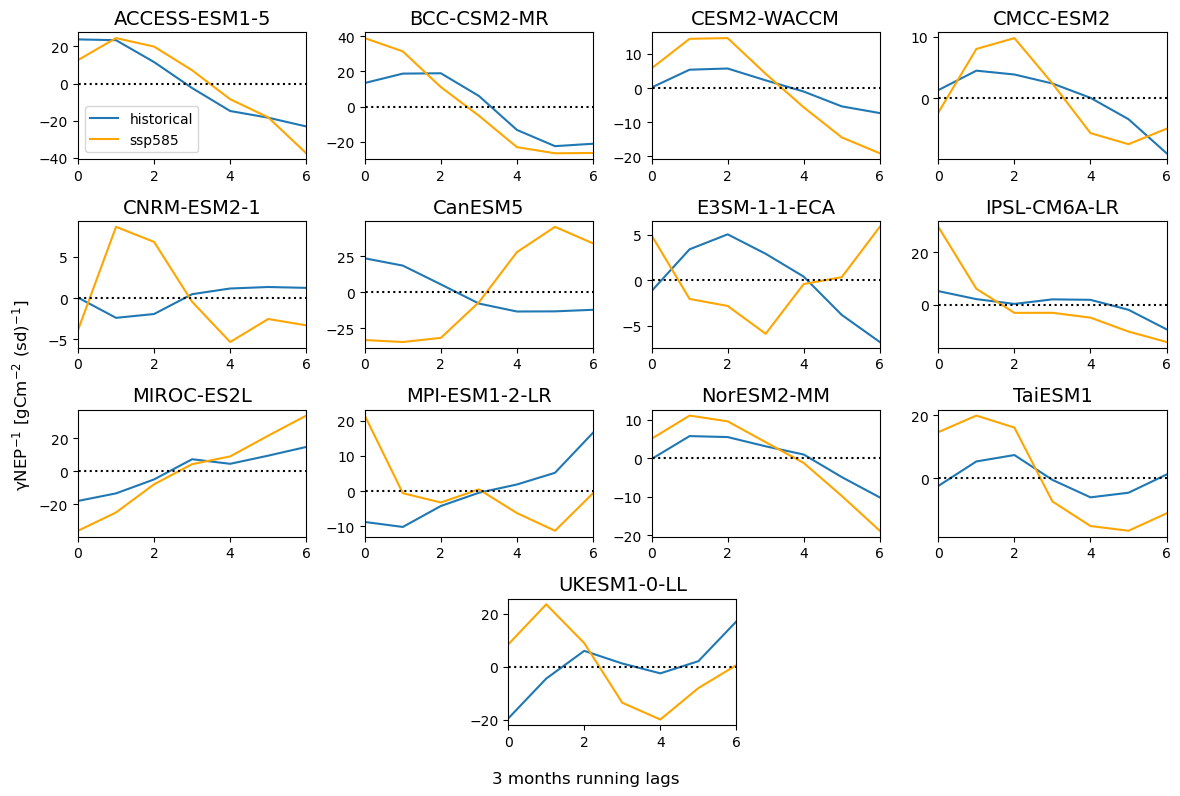

In [50]:
fig = plt.figure(figsize=(12, 8)) #, constrained_layout=True)
gs = gridspec.GridSpec(4, 8)

# Iteratively create subplots
for i, ax in enumerate(coef_hist_amz):

    if i < 4:
        ax = fig.add_subplot(gs[0, 2 * i : 2 * i + 2])
    if ((i > 3) and (i < 8)):
        ax = fig.add_subplot(gs[1, 2 * i - 8 : 2 * i - 6])
    if ((i > 7) and (i < 12)):
        ax = fig.add_subplot(gs[2, 2 * i - 16 : 2 * i -14])
    if i > 11:
        ax = fig.add_subplot(gs[3, 2 * i - 21 : 2 * i -19])

    ax.plot(coef_hist_amz[i]*-1)
    ax.plot(coef_ssp_amz[i]*-1, color = "orange")
    ax.hlines(0, -1, 7, color = "black", linestyles=":")
    ax.set_xlim(0, 6)
    # ax.set_xticks(["DJF","JFM","FMA","MAM","AMJ","MJJ","JJA"])
    # ax.set_xlabel("3 months running lags")
    # ax.set_ylabel("gCm$^{-2}$ (sd)$^{-1}$")
    if i == 0:
        ax.legend(["historical", "ssp585"])
    ax.set_title(sorted(list(set(esm)))[i],fontsize=14)  
    # ax.label_outer()

fig.supxlabel("3 months running lags")
fig.supylabel("\u03B3NEP$^{-1}$ [gCm$^{-2}$ (sd)$^{-1}$]")

fig.subplots_adjust(bottom=0.2, top=0.95, left=0.1, right=0.8, wspace=0.0, hspace=0.25)
fig.tight_layout()

### Teleconnection Lag test 3

- Testing the correlation-regression coefficient of rolling 3 months mean effect
- Nino3.4: 3 months rolling mean
- NEP: 3 months rolling mean with shift of one month ahead

In [35]:
nino34_hist = [a.sel(time = slice("1901-01", "1960-12")) for a in nino34_hist]
nino34_ssp = [a.sel(time = slice("2041-01", "2100-12")) for a in nino34_ssp]

# Select rolling seasons

ds_hist_nep_lag = []
for i, item in enumerate(ds_hist_nep):
    content = item.rolling(time = 3).mean()                # Compute 3 months running mean
    months = np.arange(6)
    lags = []; str = "lag"
    for m in months:
        shift = content.shift(time = m).rename(f"{str}{m}").assign_coords(time = nino34_hist[i].time)     # Shift time of 1 month to get 3 months impacts
        lags.append(shift)
    lag = xr.concat(lags, dim = "lags")#.assign_coords(time = nino34_hist_djf[i].time)
    ds_hist_nep_lag.append(lag)

ds_ssp_nep_lag = []
for i, item in enumerate(ds_ssp_nep):
    content = item.rolling(time = 3).mean()                # Compute 3 months running mean
    months = np.arange(6)
    lags = []
    for m in months:
        shift = content.shift(time = m).rename(f"{str}{m}").assign_coords(time = nino34_ssp[i].time)     # Shift time of 1 month to get 3 months impacts
        lags.append(shift)
    lag = xr.concat(lags, dim = "lags")#.assign_coords(time = nino34_ssp_djf[i].time)
    ds_ssp_nep_lag.append(lag)


In [44]:

def lag_regress(x, y, lagx=0, lagy=0):
    """
    Input: Two xr.Datarrays of any dimensions with the first dim being time. 
    Thus the input data could be a 1D time series, or for example, have three dimensions (time,lat,lon). 
    Datasets can be provied in any order, but note that the regression slope and intercept will be calculated
    for y with respect to x.
    Output: Covariance, correlation, regression slope and intercept, p-value, and standard error on regression
    between the two datasets along their aligned time dimension.  
    Lag values can be assigned to either of the data, with lagx shifting x, and lagy shifting y, with the specified lag amount. 
    """ 
    #1. Ensure that the data are properly alinged to each other. 
    x,y = xr.align(x,y)
    #2. Add lag information if any, and shift the data accordingly
    if lagx!=0:
        #If x lags y by 1, x must be shifted 1 step backwards. 
        #But as the 'zero-th' value is nonexistant, xr assigns it as invalid (nan). Hence it needs to be dropped
        x   = x.shift(time = -lagx).dropna(dim='time')
        #Next important step is to re-align the two datasets so that y adjusts to the changed coordinates of x
        x,y = xr.align(x,y)
    if lagy!=0:
        y   = y.shift(time = -lagy).dropna(dim='time')
        x,y = xr.align(x,y)
    #3. Compute data length, mean and standard deviation along time axis for further use: 
    n     = x.shape[0]; xmean = x.mean(axis=0); ymean = y.mean(axis=0); xstd  = x.std(axis=0); ystd  = y.std(axis=0)
    #4. Compute covariance and correlation along time axis
    cov   =  np.sum((x - xmean)*(y - ymean), axis=0)/(n); cor   = cov/(xstd*ystd)
    #6. Compute regression slope and intercept:
    slope     = cov/(xstd**2)
    intercept = ymean - xmean*slope
    y_pred =  intercept + slope*x
    res = y - y_pred
    #7. Compute P-value and standard error
    #Compute t-statistics
    tstats = cor*np.sqrt(n-2)/np.sqrt(1-cor**2); stderr = slope/tstats
    from scipy.stats import t
    pval   = t.sf(tstats, n-2)*2
    pval   = xr.DataArray(pval, dims=cor.dims, coords=cor.coords)
    #return cov,cor,slope,intercept,pval,stderr
    return slope

coef_hist = []
for i, item in enumerate(ds_hist_nep):
    X = nino34_hist[i]/nino34_hist[i].std(dim = "time")
    coef = lag_regress(X,ds_hist_nep_lag[i].sel(lon= slice(260,340)))
    coef_hist.append(coef)

coef_ssp = []
for i, item in enumerate(ds_ssp_nep):
    X = nino34_ssp[i]/nino34_ssp[i].std(dim = "time")
    coef = lag_regress(X,ds_ssp_nep_lag[i].sel(lon= slice(260,340)))
    coef_ssp.append(coef)

In [47]:
# Zonal Mean in Amazon basin
# Need to convert "object" type to "float64"
coef_hist_amz = [zonal_stat(a.astype("float64"), geodf).sel(region = 1) for a in coef_hist]
coef_ssp_amz = [zonal_stat(a.astype("float64"), geodf).sel(region = 1) for a in coef_ssp]

# Mean ESMs response
coef_hist_amz = xr_mean_list(xr.concat(coef_hist_amz, dim = "esm"), esm)
coef_ssp_amz = xr_mean_list(coef_ssp_amz, esm)


# Convert to pandas DF
coef_hist_amz_df = [a.rename("nolag").to_dataframe().rename(columns={'nolag': 'value'}).drop(columns = ["region"]) for a in coef_hist_amz]
coef_ssp_amz_df = [a.rename("nolag").to_dataframe().rename(columns={'nolag': 'value'}).drop(columns = ["region"]) for a in coef_ssp_amz]

ValueError: cannot convert an unnamed DataArray to a DataFrame: use the ``name`` parameter

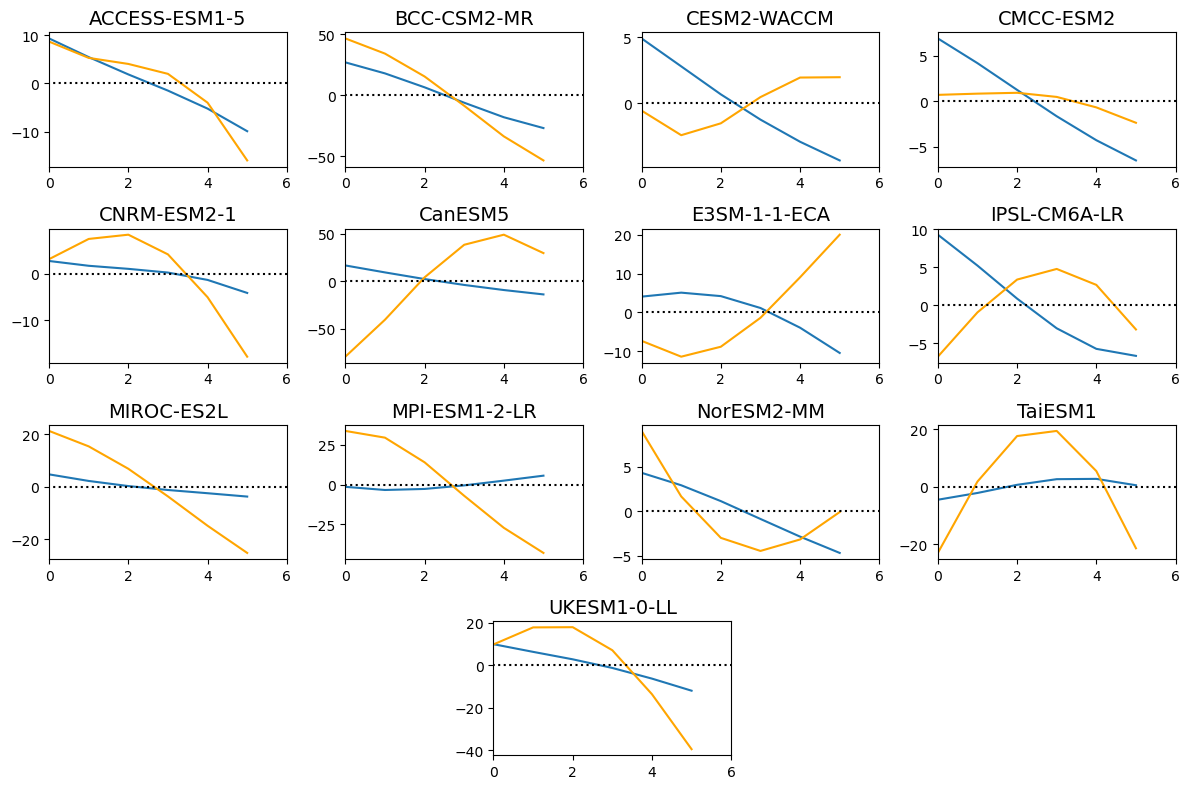

In [51]:
fig = plt.figure(figsize=(12, 8)) #, constrained_layout=True)
gs = gridspec.GridSpec(4, 8)

# Iteratively create subplots
for i, ax in enumerate(coef_hist_amz):

    if i < 4:
        ax = fig.add_subplot(gs[0, 2 * i : 2 * i + 2])
    if ((i > 3) and (i < 8)):
        ax = fig.add_subplot(gs[1, 2 * i - 8 : 2 * i - 6])
    if ((i > 7) and (i < 12)):
        ax = fig.add_subplot(gs[2, 2 * i - 16 : 2 * i -14])
    if i > 11:
        ax = fig.add_subplot(gs[3, 2 * i - 21 : 2 * i -19])

    ax.plot(coef_hist_amz[i]*-1)
    ax.plot(coef_ssp_amz[i]*-1, color = "orange")
    ax.hlines(0, -1, 7, color = "black", linestyles=":")
    ax.set_xlim(0, 6)
    # ax.set_xticks(["DJF"])
    ax.set_xlabel("")
    ax.set_title(sorted(list(set(esm)))[i],fontsize=14)  

fig.subplots_adjust(bottom=0.2, top=0.95, left=0.1, right=0.8, wspace=0.0, hspace=0.25)
fig.tight_layout()

### Ridge Reg with ENSO signal

ENSO is linearly removed from original variables signal, The residuals are then used in the ridge regression 

In [14]:
# Estimate the residuals of regression with nino34 to isolate its effect on pr and tas
seas = "DJF"

# Reshape variables
X1 = [a.sel(time = a.time.dt.season==seas) for a in nino34_hist]
Y = [a.sel(time = a.time.dt.season==seas) for a in ds_hist_pr]
Y1 = [a.sel(time = a.time.dt.season==seas) for a in ds_hist_tas]
# Y2 = [a.sel(time = a.time.dt.season==seas) for a in ds_hist_mrso]
Y3 = [a.sel(time = a.time.dt.season==seas) for a in ds_hist_rsds]
Y4 = [a.sel(time = a.time.dt.season==seas) for a in ds_hist_hfls]

res_pr_hist = []
res_tas_hist = []
# res_mrso_hist = []
res_rsds_hist = []
res_hfls_hist = []
for i, item in enumerate(ds_hist_nep):

    content = lag_linregress_3D(X1[i],Y[i])
    content1 = lag_linregress_3D(X1[i],Y1[i])
    # content2 = lag_linregress_3D(X1[i],Y2[i])
    content3 = lag_linregress_3D(X1[i],Y3[i])
    content4 = lag_linregress_3D(X1[i],Y4[i])

    res_pr_hist.append(content)
    res_tas_hist.append(content1)
    # res_mrso_hist.append(content2)
    res_rsds_hist.append(content3)
    res_hfls_hist.append(content4)

# Reshape variables
X1 = [a.sel(time = a.time.dt.season==seas) for a in nino34_ssp]
Y = [a.sel(time = a.time.dt.season==seas) for a in ds_ssp_pr]
Y1 = [a.sel(time = a.time.dt.season==seas) for a in ds_ssp_tas]
# Y2 = [a.sel(time = a.time.dt.season==seas) for a in ds_ssp_mrso]
Y3 = [a.sel(time = a.time.dt.season==seas) for a in ds_ssp_rsds]
Y4 = [a.sel(time = a.time.dt.season==seas) for a in ds_ssp_hfls]

res_pr_ssp = []
res_tas_ssp = []
# res_mrso_ssp = []
res_rsds_ssp = []
res_hfls_ssp = []
for i, item in enumerate(ds_ssp_nep):

    content = lag_linregress_3D(X1[i],Y[i])
    content1 = lag_linregress_3D(X1[i],Y1[i])
    # content2 = lag_linregress_3D(X1[i],Y2[i])
    content3 = lag_linregress_3D(X1[i],Y3[i])
    content4 = lag_linregress_3D(X1[i],Y4[i])

    res_pr_ssp.append(content)
    res_tas_ssp.append(content1)
    # res_mrso_ssp.append(content2)
    res_rsds_ssp.append(content3)
    res_hfls_ssp.append(content4)

In [15]:
# i = 0
# mask = res_mrso_hist[i].rename("mrso").sel(lon= slice(260,340)).stack(cell = ["lon","lat"]).dropna(dim = "cell", how = "any").cell.values
# test = res_pr_hist[i].sel(lon= slice(260,340)).stack(cell = ["lon","lat"])
# test.where(test.cell.values == mask)#.dropna(dim = "cell", how = "any")
# # test.cell


### Calculation

To avoid Singular Matrix error while performing regression it's necessary to fill NaN NOT with zero but with a not-zero number (eg 0.001) 

By standardizing Soil Moisturre SSP with historical Soil Moisture we get infinite values for some realization. Thus substitute inf with 0.001

In [16]:
from sklearn import linear_model
from regressors import stats   

# Define regression technique
# Ridge Regression with Cross-Validation
# alphas = np.linspace(.000001, 1)
# alphas = np.logspace(-6, 2, 10)
# ridge = linear_model.RidgeCV(alphas = alphas, cv =5)

# Ridge Regression without Cross-Validation
ridge = linear_model.Ridge()

# historical
coef_ridge_hist = []
r2_ridge_hist = []
pred_ridge_hist = []
pval_ridge_hist = []
for i, item in enumerate(ds_hist_nep):
    
        
        #1. Reshape variables
        ensohist = nino34_hist[i].rename("sst").sel(time = nino34_hist[i].time.dt.season==seas).sel(time = slice("1901-01", "1960-12"))
        X1hist = res_pr_hist[i].rename("pr").sel(lon= slice(260,340))
        X2hist = res_tas_hist[i].rename("tas").sel(lon= slice(260,340))
        # X3hist = res_mrso_hist[i].rename("mrso").fillna(0.001).sel(lon= slice(260,340))
        X4hist = res_rsds_hist[i].rename("rsds").sel(lon= slice(260,340))
        X5hist = res_hfls_hist[i].rename("hfls").sel(lon= slice(260,340))

        Y = ds_hist_nep[i].sel(lon= slice(260,340)).fillna(0.001).sel(time = ds_hist_nep[i].time.dt.season=="MAM")

        #2. Standardize predictors
        ensohist = ensohist/ensohist.std(dim = ["time"])
        X1hist = X1hist/X1hist.std(dim = "time")
        X2hist = X2hist/X2hist.std(dim = "time")
        # X3hist = (X3hist/X3hist.std(dim = "time")).fillna(0.001)
        X4hist = (X4hist/X4hist.std(dim = "time"))
        X5hist = X5hist/X5hist.std(dim = "time")

        #3. Stack on 1D vector
        ensohist = ensohist.stack(cell = ["time"])
        X1hist = X1hist.stack(cell = ["lon","lat"])
        X2hist = X2hist.stack(cell = ["lon","lat"])
        # X3hist = X3hist.stack(cell = ["lon","lat"])
        X4hist = X4hist.stack(cell = ["lon","lat"])
        X5hist = X5hist.stack(cell = ["lon","lat"])

        Y = Y.stack(cell = ["lon","lat"])

        #4. Create Dataarray with ENSO signal in every grid cell to perform regression
        Xenso = xr.DataArray(data=None, coords=[X1hist.time, X1hist.cell], dims=["time","cell"])
        for c in Xenso.cell:
            locator = {'cell':c}
            Xenso.loc[locator] = ensohist.values
            Xenso.values = Xenso.values.astype("float64")       # To avoid the resulting values are "object" rather than "float64" 
        Xenso = Xenso.rename("sst")

        #5. Create empty dataarray to store regression coefficients
        coef = xr.DataArray(data=None, coords=[X1hist.time,X1hist.cell], dims=["time","cell"])
        coef["pr"] =  xr.DataArray(data=None, coords=[X1hist.cell], dims=["cell"])
        coef["tas"] =  xr.DataArray(data=None, coords=[X1hist.cell], dims=["cell"])
        # coef["mrso"] =  xr.DataArray(data=None, coords=[X1hist.cell], dims=["cell"])
        coef["sst"] =  xr.DataArray(data=None, coords=[X1hist.cell], dims=["cell"])
        coef["rsds"] =  xr.DataArray(data=None, coords=[X1hist.cell], dims=["cell"])
        coef["hfls"] =  xr.DataArray(data=None, coords=[X1hist.cell], dims=["cell"])

        # Create empty dataarray to store p-values
        pval = xr.DataArray(data=None, coords=[X1hist.cell], dims=["cell"])
        pval["pr"] = xr.DataArray(data=None, coords=[X1hist.cell], dims=["cell"])
        pval["tas"] = xr.DataArray(data=None, coords=[X1hist.cell], dims=["cell"])
        # pval["mrso"] = xr.DataArray(data=None, coords=[X1hist.cell], dims=["cell"])
        pval["sst"] = xr.DataArray(data=None, coords=[X1hist.cell], dims=["cell"])
        pval["rsds"] =  xr.DataArray(data=None, coords=[X1hist.cell], dims=["cell"])
        pval["hfls"] =  xr.DataArray(data=None, coords=[X1hist.cell], dims=["cell"])

        # Create empty datarray to store R2 and Y predicted 
        r_squared = xr.DataArray(data=None, coords=[X1hist.cell], dims=["cell"])
        pred = xr.DataArray(data=None, coords=[Y.time, Y.cell], dims=["time","cell"])
        pred["nep"] = xr.DataArray(data=None, coords=[Y.time, Y.cell], dims=["time", "cell"])

        #6. Iterate over cells (lan*lon)
        for c in X1hist.cell:
            locator = {'cell':c}

            # merge predictors in one numpy array
            df = np.array((X1hist.loc[locator].values, X2hist.loc[locator].values, X4hist.loc[locator].values, X5hist.loc[locator].values, Xenso.loc[locator].values)); df = df.T
            
            model = ridge.fit(df,Y.loc[locator].values)
            r2 = ridge.score(df,Y.loc[locator])
            ypred = ridge.predict(df)

            coef["pr"].loc[locator] = model.coef_[0]
            coef["tas"].loc[locator] = model.coef_[1]
            # coef["mrso"].loc[locator] = model.coef_[2]
            coef["rsds"].loc[locator] = model.coef_[2]
            coef["hfls"].loc[locator] = model.coef_[3]
            coef["sst"].loc[locator] = model.coef_[4]

            # # p-value of the index "0" refers to the intercept
            pval["pr"].loc[locator] = stats.coef_pval(model,df,Y.loc[locator].values)[1]
            pval["tas"].loc[locator] = stats.coef_pval(model,df,Y.loc[locator].values)[2]
            # pval["mrso"].loc[locator] = stats.coef_pval(model,df,Y.loc[locator].values)[3]
            pval["rsds"].loc[locator] = stats.coef_pval(model,df,Y.loc[locator].values)[3]
            pval["hfls"].loc[locator] = stats.coef_pval(model,df,Y.loc[locator].values)[4]
            pval["sst"].loc[locator] = stats.coef_pval(model,df,Y.loc[locator].values)[5]
            
            r_squared.loc[locator] = r2
            pred["nep"].loc[locator] = ypred

        #7. Unstack array
        coef = coef.unstack()
        coef = xr.concat([coef.pr, coef.tas, coef.rsds, coef.hfls, coef.sst], dim = "coefficients")     #ORDER of the coefficients
        coef["pr"] = coef.pr.astype(np.float64)
        coef["tas"] = coef.tas.astype(np.float64)
        # # coef["mrso"] = coef.mrso.astype(np.float64)
        coef["rsds"] = coef.rsds.astype(np.float64)
        coef["hfls"] = coef.hfls.astype(np.float64)
        coef["sst"] = coef.sst.astype(np.float64)

        pval = pval.unstack()
        pval = xr.concat([pval.pr, pval.tas, pval.rsds, pval.hfls, pval.sst], dim = "p-values")
        pval["pr"] = pval.pr.astype(np.float64)
        pval["tas"] = pval.tas.astype(np.float64)
        # # pval["mrso"] = pval.mrso.astype(np.float64)
        pval["rsds"] = pval.rsds.astype(np.float64)
        pval["hfls"] = pval.hfls.astype(np.float64)
        pval["sst"] = pval.sst.astype(np.float64)
        
        r_squared = r_squared.astype(np.float64).unstack()
        pred = pred.astype(np.float64).unstack()

        coef_ridge_hist.append(coef)
        r2_ridge_hist.append(r_squared)
        pred_ridge_hist.append(pred)
        pval_ridge_hist.append(pval)
        print("historical_" + esm[i])



# SSP585
coef_ridge_ssp = []
r2_ridge_ssp = []
pred_ridge_ssp = []
pval_ridge_ssp = []
for i, item in enumerate(ds_ssp_nep):

        # Reshape variables
        ensossp = nino34_ssp[i].rename("sst").sel(time = nino34_ssp[i].time.dt.season==seas).sel(time = slice("2041-01", "2100-12"))
        X1ssp = res_pr_ssp[i].rename("pr").sel(lon= slice(260,340))
        X2ssp = res_tas_ssp[i].rename("tas").sel(lon= slice(260,340))
        # # X3ssp = res_mrso_ssp[i].rename("mrso").fillna(0.001).sel(lon= slice(260,340))
        X4ssp = res_rsds_ssp[i].rename("rsds").sel(lon= slice(260,340))
        X5ssp = res_hfls_ssp[i].rename("hfls").sel(lon= slice(260,340))

        Y = ds_ssp_nep[i].sel(lon= slice(260,340)).fillna(0.001).sel(time = ds_ssp_nep[i].time.dt.season=="MAM")

        # Need to redefine historical dataset for standardization 
        ensohist = nino34_hist[i].rename("sst").sel(time = nino34_hist[i].time.dt.season==seas).sel(time = slice("1901-01", "1960-12"))
        X1hist = res_pr_hist[i].rename("pr").sel(lon= slice(260,340))
        X2hist = res_tas_hist[i].rename("tas").sel(lon= slice(260,340))
        # # X3hist = res_mrso_hist[i].rename("mrso").fillna(0.001).sel(lon= slice(260,340))
        X4hist = res_rsds_hist[i].rename("rsds").sel(lon= slice(260,340))
        X5hist = res_hfls_hist[i].rename("hfls").sel(lon= slice(260,340))

        # Standardize predictors
        ensossp = ensossp/ensohist.std(dim = ["time"])
        X1ssp = X1ssp/X1hist.std(dim = "time")
        X2ssp = X2ssp/X2hist.std(dim = "time")
        # X3ssp = xr.where((X3ssp/X3hist.std(dim = "time")).fillna(0.001) == np.inf, 0.001, (X3ssp/X3hist.std(dim = "time"))).fillna(0.001)     # sometimes it could happen to have Inf values
        X4ssp = (X4ssp/X4hist.std(dim = "time"))
        X5ssp = (X5ssp/X5hist.std(dim = "time"))

        # Stack on 1D vector
        ensossp = ensossp.stack(cell = ["time"])
        X1ssp = X1ssp.stack(cell = ["lon","lat"])
        X2ssp = X2ssp.stack(cell = ["lon","lat"])
        # X3ssp = X3ssp.stack(cell = ["lon","lat"])
        X4ssp = X4ssp.stack(cell = ["lon","lat"])
        X5ssp = X5ssp.stack(cell = ["lon","lat"])

        Y = Y.stack(cell = ["lon","lat"])
        
        # Create Dataarray with ENSO signal in every grid cell to perform regression
        Xenso = xr.DataArray(data=None, coords=[X1ssp.time, X1ssp.cell], dims=["time","cell"])
        for c in Xenso.cell:
            locator = {'cell':c}
            Xenso.loc[locator] = ensossp.values
            Xenso.values = Xenso.values.astype("float64")       # To avoid the resulting values are "object" rather than "float64" 
        Xenso = Xenso.rename("sst")

        # Create empty dataarray to store regression coefficients
        coef = xr.DataArray(data=None, coords=[X1ssp.time,X1ssp.cell], dims=["time","cell"])
        coef["pr"] =  xr.DataArray(data=None, coords=[X1ssp.cell], dims=["cell"])
        coef["tas"] =  xr.DataArray(data=None, coords=[X1ssp.cell], dims=["cell"])
        # coef["mrso"] =  xr.DataArray(data=None, coords=[X1ssp.cell], dims=["cell"])
        coef["sst"] =  xr.DataArray(data=None, coords=[X1ssp.cell], dims=["cell"])
        coef["rsds"] =  xr.DataArray(data=None, coords=[X1ssp.cell], dims=["cell"])
        coef["hfls"] =  xr.DataArray(data=None, coords=[X1ssp.cell], dims=["cell"])

        # Create empty dataarray to store p-values
        pval = xr.DataArray(data=None, coords=[X1ssp.cell], dims=["cell"])
        pval["pr"] = xr.DataArray(data=None, coords=[X1ssp.cell], dims=["cell"])
        pval["tas"] = xr.DataArray(data=None, coords=[X1ssp.cell], dims=["cell"])
        # pval["mrso"] = xr.DataArray(data=None, coords=[X1ssp.cell], dims=["cell"])
        pval["sst"] = xr.DataArray(data=None, coords=[X1ssp.cell], dims=["cell"])
        pval["rsds"] =  xr.DataArray(data=None, coords=[X1ssp.cell], dims=["cell"])
        pval["hfls"] =  xr.DataArray(data=None, coords=[X1ssp.cell], dims=["cell"])

        # Create empty datarray to store R2 and Y predicted 
        r_squared = xr.DataArray(data=None, coords=[X1ssp.cell], dims=["cell"])
        pred = xr.DataArray(data=None, coords=[Y.time, Y.cell], dims=["time","cell"])
        pred["nep"] = xr.DataArray(data=None, coords=[Y.time, Y.cell], dims=["time", "cell"])

        for c in X1ssp.cell:
            locator = {'cell':c}

            # merge predictors in one dataarray
            df = np.array((X1ssp.loc[locator].values, X2ssp.loc[locator].values, X4ssp.loc[locator].values, X5ssp.loc[locator].values,Xenso.loc[locator].values)); df = df.T
            model = ridge.fit(df,Y.loc[locator].values)
            r2 = ridge.score(df,Y.loc[locator])
            ypred = ridge.predict(df)

            coef["pr"].loc[locator] = model.coef_[0]
            coef["tas"].loc[locator] = model.coef_[1]
            # coef["mrso"].loc[locator] = model.coef_[2]
            coef["rsds"].loc[locator] = model.coef_[2]
            coef["hfls"].loc[locator] = model.coef_[3]
            coef["sst"].loc[locator] = model.coef_[4]

            # p-value of the index "0" refers to the intercept
            pval["pr"].loc[locator] = stats.coef_pval(model,df,Y.loc[locator].values)[1]
            pval["tas"].loc[locator] = stats.coef_pval(model,df,Y.loc[locator].values)[2]
            # pval["mrso"].loc[locator] = stats.coef_pval(model,df,Y.loc[locator].values)[3]
            pval["rsds"].loc[locator] = stats.coef_pval(model,df,Y.loc[locator].values)[3]
            pval["hfls"].loc[locator] = stats.coef_pval(model,df,Y.loc[locator].values)[4]
            pval["sst"].loc[locator] = stats.coef_pval(model,df,Y.loc[locator].values)[5]
            
            r_squared.loc[locator] = r2
            pred["nep"].loc[locator] = ypred

        coef = coef.unstack()
        coef = xr.concat([coef.pr, coef.tas, coef.rsds, coef.hfls, coef.sst], dim = "coefficients")
        coef["pr"] = coef.pr.astype(np.float64)
        coef["tas"] = coef.tas.astype(np.float64)
        # # coef["mrso"] = coef.mrso.astype(np.float64)
        coef["rsds"] = coef.rsds.astype(np.float64)
        coef["hfls"] = coef.hfls.astype(np.float64)
        coef["sst"] = coef.sst.astype(np.float64)

        pval = pval.unstack()
        pval = xr.concat([pval.pr, pval.tas, pval.rsds, pval.hfls, pval.sst], dim = "p-values")
        pval["pr"] = pval.pr.astype(np.float64)
        pval["tas"] = pval.tas.astype(np.float64)
        # # pval["mrso"] = pval.mrso.astype(np.float64)
        pval["rsds"] = pval.rsds.astype(np.float64)
        pval["hfls"] = pval.hfls.astype(np.float64)
        pval["sst"] = pval.sst.astype(np.float64)
        
        r_squared = r_squared.astype(np.float64).unstack()
        pred = pred.astype(np.float64).unstack()

        coef_ridge_ssp.append(coef)
        r2_ridge_ssp.append(r_squared)
        pred_ridge_ssp.append(pred)
        pval_ridge_ssp.append(pval)
        print("ssp585_" + esm[i])
        

    

# Save and export regression list data
import pickle
data_path = 'G:/Shared drives/Amazon_ENSO_work/analysis/'

with open(os.path.join(data_path+"ridge_reg_enso_hist_1901-1960_coef_c_lag"), "wb") as fp:   #Pickling
    pickle.dump(coef_ridge_hist, fp)
with open(os.path.join(data_path+"ridge_reg_enso_ssp_2041-2100_coef_c_lag"), "wb") as fp:   #Pickling
    pickle.dump(coef_ridge_ssp, fp)

with open(os.path.join(data_path+"ridge_reg_enso_hist_1901-1960_pval_c_lag"), "wb") as fp:   #Pickling
    pickle.dump(pval_ridge_hist, fp)
with open(os.path.join(data_path+"ridge_reg_enso_ssp_2041-2100_pval_c_lag"), "wb") as fp:   #Pickling
    pickle.dump(pval_ridge_ssp, fp)

with open(os.path.join(data_path+"ridge_reg_enso_hist_1901-1960_r2_c_lag"), "wb") as fp:   #Pickling
    pickle.dump(r2_ridge_hist, fp)
with open(os.path.join(data_path+"ridge_reg_enso_ssp_2041-2100_r2_c_lag"), "wb") as fp:   #Pickling
    pickle.dump(r2_ridge_ssp, fp)

with open(os.path.join(data_path+"ridge_reg_enso_hist_1901-1960_ypred_c_lag"), "wb") as fp:   #Pickling
    pickle.dump(pred_ridge_hist, fp)
with open(os.path.join(data_path+"ridge_reg_enso_ssp_2041-2100_ypred_c_lag"), "wb") as fp:   #Pickling
    pickle.dump(pred_ridge_ssp, fp)



ssp585_ACCESS-ESM1-5
ssp585_ACCESS-ESM1-5
ssp585_ACCESS-ESM1-5
ssp585_ACCESS-ESM1-5
ssp585_ACCESS-ESM1-5
ssp585_BCC-CSM2-MR
ssp585_CESM2-WACCM
ssp585_CESM2-WACCM
ssp585_CESM2-WACCM
ssp585_CMCC-ESM2
ssp585_CNRM-ESM2-1
ssp585_CNRM-ESM2-1
ssp585_CNRM-ESM2-1
ssp585_CNRM-ESM2-1
ssp585_CNRM-ESM2-1
ssp585_CanESM5
ssp585_CanESM5
ssp585_CanESM5
ssp585_CanESM5
ssp585_CanESM5
ssp585_E3SM-1-1-ECA
ssp585_IPSL-CM6A-LR
ssp585_IPSL-CM6A-LR
ssp585_IPSL-CM6A-LR
ssp585_IPSL-CM6A-LR
ssp585_IPSL-CM6A-LR
ssp585_MIROC-ES2L
ssp585_MIROC-ES2L
ssp585_MIROC-ES2L
ssp585_MIROC-ES2L
ssp585_MIROC-ES2L
ssp585_MPI-ESM1-2-LR
ssp585_MPI-ESM1-2-LR
ssp585_MPI-ESM1-2-LR
ssp585_MPI-ESM1-2-LR
ssp585_MPI-ESM1-2-LR
ssp585_NorESM2-MM
ssp585_TaiESM1
ssp585_UKESM1-0-LL
ssp585_UKESM1-0-LL
ssp585_UKESM1-0-LL
ssp585_UKESM1-0-LL
ssp585_UKESM1-0-LL


In [48]:
# Open regression list data

import pickle

data_path = 'G:/Shared drives/Amazon_ENSO_work/analysis/'

with open(os.path.join(data_path+"ridge_reg_enso_hist_1901-1960_coef_c_lag"), "rb") as fp:   #Pickling
    coef_ridge_hist = pickle.load(fp)
with open(os.path.join(data_path+"ridge_reg_enso_ssp_2041-2100_coef_c_lag"), "rb") as fp:   #Pickling
    coef_ridge_ssp = pickle.load(fp)

with open(os.path.join(data_path+"ridge_reg_enso_hist_1901-1960_pval_c_lag"), "rb") as fp:   #Pickling
    pval_ridge_hist = pickle.load(fp)
with open(os.path.join(data_path+"ridge_reg_enso_ssp_2041-2100_pval_c_lag"), "rb") as fp:   #Pickling
    pval_ridge_ssp = pickle.load(fp)

with open(os.path.join(data_path+"ridge_reg_enso_hist_1901-1960_r2_c_lag"), "rb") as fp:   #Pickling
    r2_ridge_hist = pickle.load(fp)
with open(os.path.join(data_path+"ridge_reg_enso_ssp_2041-2100_r2_c_lag"), "rb") as fp:   #Pickling
    r2_ridge_ssp = pickle.load(fp)

with open(os.path.join(data_path+"ridge_reg_enso_hist_1901-1960_ypred_c_lag"), "rb") as fp:   #Pickling
    pred_ridge_hist = pickle.load(fp)
with open(os.path.join(data_path+"ridge_reg_enso_ssp_2041-2100_ypred_c_lag"), "rb") as fp:   #Pickling
    pred_ridge_ssp = pickle.load(fp)

In [49]:
# MLR_b = ridge regression with residuals of pr,tas,enso,rsds,hfls \
# MLR_c = 5-fold CV Ridge Regression with resisuals of pr,tas,enso,rsds,hfls  \
# Because I forgot to concatenate the results of the MLR calculation 

coef_ridge_hist = [xr.concat([a.pr, a.tas, a.sst, a.rsds, a.hfls], dim = "coefficients") for a in coef_ridge_hist]
coef_ridge_ssp = [xr.concat([a.pr, a.tas, a.sst, a.rsds, a.hfls], dim = "coefficients") for a in coef_ridge_ssp]

pval_ridge_hist = [xr.concat([a.pr, a.tas, a.sst, a.rsds, a.hfls], dim = "pvalues") for a in pval_ridge_hist]
pval_ridge_ssp = [xr.concat([a.pr, a.tas, a.sst, a.rsds, a.hfls], dim = "pvalues") for a in pval_ridge_ssp]

pred_ridge_hist = [a.nep for a in pred_ridge_hist]
pred_ridge_ssp = [a.nep for a in pred_ridge_ssp]

## Model Diversity and Predictor Diversity

Calculate Zonal means

In [50]:
# Zonal mean of REAN and ESM

import json
import os
import glob
import geopandas as gpd
from importlib.machinery import SourceFileLoader
# imports the module from the given path
gpd = SourceFileLoader("geopandas","C:/Users/mastr/miniconda3/pkgs/geopandas-0.7.0-py_1/site-packages/geopandas/__init__.py").load_module()
import regionmask

def cell_weight(ds):
    R = 6.371e6
    dϕ = np.deg2rad(ds.lat[1] - ds.lat[0])
    dλ = np.deg2rad(ds.lon[1] - ds.lon[0])
    dlat = R * dϕ * xr.ones_like(ds.lon)
    dlon = R * dλ * np.cos(np.deg2rad(ds.lat))
    cell_area = dlon * dlat
    return(cell_area)

def mask_shape(ds,gdf):
    # Create mask of multiple regions from shapefile
    mask = regionmask.mask_3D_geopandas(
            gdf,
            ds.lon,
            ds.lat,
            drop=True
        )
    ds_m = ds.where(mask)
    return ds_m

def zonal_stat(ds,gdf):
    # Create mask of multiple regions from shapefile
    mask = regionmask.mask_3D_geopandas(
            gdf,
            ds.lon,
            ds.lat,
            drop=True
        )
    # Apply mask to xarray
    ds_m = ds.where(mask)
    # Calculate cell area of the xarray
    cell_area = cell_weight(ds)
    # Zonal statistic for all the regions
    ds_z = ds_m.weighted(cell_area).mean(["lat","lon"])
    # ds_z = ds_z.groupby("region").mean()
    return ds_z

# geodf = gpd.read_file((os.path.join('C:/Users/mastr/Documents/Amazon/amazon_border/biome.shp')))
geodf = gpd.read_file((os.path.join('C:/Users/mastr/Documents/Amazon/hybas_sa_lev01-12_v1c/hybas_sa_lev02_v1c.shp')))

In [51]:
# Zonal Mean in Amazon basin 
# Need to convert "object" type to "float64"

coef_ridge_hist_amz = [zonal_stat(a.astype("float64"), geodf).sel(region = 1) for a in coef_ridge_hist]
coef_ridge_ssp_amz = [zonal_stat(a.astype("float64"), geodf).sel(region = 1) for a in coef_ridge_ssp]

pval_ridge_hist_amz = [zonal_stat(a.astype("float64"), geodf).sel(region = 1) for a in pval_ridge_hist]
pval_ridge_ssp_amz = [zonal_stat(a.astype("float64"), geodf).sel(region = 1) for a in pval_ridge_ssp]

r2_ridge_hist_amz = [zonal_stat(a.astype("float64") , geodf).sel(region = 1) for a in r2_ridge_hist]
r2_ridge_ssp_amz = [zonal_stat(a.astype("float64") , geodf).sel(region = 1) for a in r2_ridge_ssp]

# NEP and NEP_pred to be initially considered as annual zonal averages
# Later on they will be averaged over time for every ESM
#  
pred_ridge_hist_amz = [zonal_stat(a.astype("float64") , geodf).sel(region = 1) for a in pred_ridge_hist]
pred_ridge_hist_amz = [a.rename("nep_pred") for a in pred_ridge_hist_amz]

pred_ridge_ssp_amz = [zonal_stat(a.astype("float64") , geodf).sel(region = 1) for a in pred_ridge_ssp]
pred_ridge_ssp_amz = [a.rename("nep_pred") for a in pred_ridge_ssp_amz]

ds_hist_nep_amz = [zonal_stat(a, geodf).sel(region = 1).sel(time = a.time.dt.season=="DJF") for a in ds_hist_nep]
ds_hist_nep_amz = [a.rename("nep") for a in ds_hist_nep_amz]

ds_ssp_nep_amz = [zonal_stat(a, geodf).sel(region = 1).sel(time = a.time.dt.season=="DJF") for a in ds_ssp_nep]
ds_ssp_nep_amz = [a.rename("nep") for a in ds_ssp_nep_amz]

In [52]:
# Average time values of NEP and NEP-predicted 

ds_hist_nep_amz= [a.mean(dim = "time") for a in ds_hist_nep_amz]
ds_ssp_nep_amz= [a.mean(dim = "time") for a in ds_ssp_nep_amz]

pred_ridge_hist_amz= [a.mean(dim = "time") for a in pred_ridge_hist_amz]
pred_ridge_ssp_amz= [a.mean(dim = "time") for a in pred_ridge_ssp_amz]


In [53]:

# The order of the coefficients is specified in the section "Import saved data"

# Separate predictors HIST
coef_ridge_hist_pr_amz = [a.sel(coefficients = 0) for a in coef_ridge_hist_amz]
coef_ridge_hist_tas_amz = [a.sel(coefficients = 1).rename("tas") for a in coef_ridge_hist_amz]
# coef_ridge_hist_mrso_amz = [a.sel(coefficients = 2).rename("mrso") for a in coef_ridge_hist_amz]
coef_ridge_hist_enso_amz = [a.sel(coefficients = 2).rename("enso") for a in coef_ridge_hist_amz]
coef_ridge_hist_rsds_amz = [a.sel(coefficients = 3).rename("rsds") for a in coef_ridge_hist_amz]
coef_ridge_hist_hfls_amz = [a.sel(coefficients = 4).rename("hfls") for a in coef_ridge_hist_amz]

r2_ridge_hist_amz = [a.rename("r2") for a in r2_ridge_hist_amz]

# Separate predictors SSP
coef_ridge_ssp_pr_amz = [a.sel(coefficients = 0) for a in coef_ridge_ssp_amz]
coef_ridge_ssp_tas_amz = [a.sel(coefficients = 1).rename("tas") for a in coef_ridge_ssp_amz]
# coef_ridge_ssp_mrso_amz = [a.sel(coefficients = 2).rename("mrso") for a in coef_ridge_ssp_amz]
coef_ridge_ssp_enso_amz = [a.sel(coefficients = 2).rename("enso") for a in coef_ridge_ssp_amz]
coef_ridge_ssp_rsds_amz = [a.sel(coefficients = 3).rename("rsds") for a in coef_ridge_ssp_amz]
coef_ridge_ssp_hfls_amz = [a.sel(coefficients = 4).rename("hfls") for a in coef_ridge_ssp_amz]

r2_ridge_ssp_amz = [a.rename("r2") for a in r2_ridge_ssp_amz]

Convert xarrays to pandas DF

In [54]:
# Convert to pandas dataframe

esm = []
for filepath in sorted(glob.glob(os.path.join('E:/Data/analysis/'+'/'+'historical'+'/'+'nep' + '_*_' + 'historical' + '_*'))):     
        content = nc.Dataset(filepath).source_id
        esm.append(content)    

import pandas as pd

df_coef_ridge_hist_pr = xr.concat(coef_ridge_hist_pr_amz, dim = "esm").to_dataframe(); df_coef_ridge_hist_pr = df_coef_ridge_hist_pr.drop(columns = "region").rename(index=dict(zip(df_coef_ridge_hist_pr.index, esm)))
df_coef_ridge_hist_tas = xr.concat(coef_ridge_hist_tas_amz, dim = "esm").to_dataframe(); df_coef_ridge_hist_tas = df_coef_ridge_hist_tas.drop(columns = "region").rename(index=dict(zip(df_coef_ridge_hist_tas.index, esm)))
df_coef_ridge_hist_enso = xr.concat(coef_ridge_hist_enso_amz, dim = "esm").to_dataframe(); df_coef_ridge_hist_enso = df_coef_ridge_hist_enso.drop(columns = "region").rename(index=dict(zip(df_coef_ridge_hist_enso.index, esm)))
df_coef_ridge_hist_rsds = xr.concat(coef_ridge_hist_rsds_amz, dim = "esm").to_dataframe(); df_coef_ridge_hist_rsds = df_coef_ridge_hist_rsds.drop(columns = "region").rename(index=dict(zip(df_coef_ridge_hist_rsds.index, esm)))
# df_coef_ridge_hist_mrso = xr.concat(coef_ridge_hist_mrso_amz, dim = "esm").to_dataframe(); df_coef_ridge_hist_mrso = df_coef_ridge_hist_mrso.drop(columns = "region").rename(index=dict(zip(df_coef_ridge_hist_mrso.index, esm)))
df_coef_ridge_hist_hfls = xr.concat(coef_ridge_hist_hfls_amz, dim = "esm").to_dataframe(); df_coef_ridge_hist_hfls = df_coef_ridge_hist_hfls.drop(columns = "region").rename(index=dict(zip(df_coef_ridge_hist_hfls.index, esm)))
# df_r2_ridge_hist = xr.concat(r2_ridge_hist, dim = "esm").to_dataframe(); df_r2_ridge_hist = df_r2_ridge_hist.drop(columns = "region").rename(index=dict(zip(df_r2_ridge_hist.index, esm)))
df_hist_nep = xr.concat(ds_hist_nep_amz, dim = "esm").to_dataframe(); df_hist_nep = df_hist_nep.drop(columns = "region").rename(index=dict(zip(df_hist_nep.index, esm)))
df_pred_ridge_hist = xr.concat(pred_ridge_hist_amz, dim = "esm").to_dataframe(); df_pred_ridge_hist = df_pred_ridge_hist.drop(columns = "region").rename(index=dict(zip(df_pred_ridge_hist.index, esm)))

df_amz_hist = pd.concat([df_pred_ridge_hist, df_hist_nep, df_coef_ridge_hist_pr, df_coef_ridge_hist_tas, df_coef_ridge_hist_enso, df_coef_ridge_hist_rsds, df_coef_ridge_hist_hfls], axis = 1)

In [55]:
# Convert to pandas dataframe
import pandas as pd

df_coef_ridge_ssp_pr = xr.concat(coef_ridge_ssp_pr_amz, dim = "esm").to_dataframe(); df_coef_ridge_ssp_pr = df_coef_ridge_ssp_pr.drop(columns = "region").rename(index=dict(zip(df_coef_ridge_ssp_pr.index, esm)))
df_coef_ridge_ssp_tas = xr.concat(coef_ridge_ssp_tas_amz, dim = "esm").to_dataframe(); df_coef_ridge_ssp_tas = df_coef_ridge_ssp_tas.drop(columns = "region").rename(index=dict(zip(df_coef_ridge_ssp_tas.index, esm)))
df_coef_ridge_ssp_enso = xr.concat(coef_ridge_ssp_enso_amz, dim = "esm").to_dataframe(); df_coef_ridge_ssp_enso = df_coef_ridge_ssp_enso.drop(columns = "region").rename(index=dict(zip(df_coef_ridge_ssp_enso.index, esm)))
df_coef_ridge_ssp_rsds = xr.concat(coef_ridge_ssp_rsds_amz, dim = "esm").to_dataframe(); df_coef_ridge_ssp_rsds = df_coef_ridge_ssp_rsds.drop(columns = "region").rename(index=dict(zip(df_coef_ridge_ssp_rsds.index, esm)))
# df_coef_ridge_ssp_mrso = xr.concat(coef_ridge_ssp_mrso_amz, dim = "esm").to_dataframe(); df_coef_ridge_ssp_mrso = df_coef_ridge_ssp_mrso.drop(columns = "region").rename(index=dict(zip(df_coef_ridge_ssp_mrso.index, esm)))
df_coef_ridge_ssp_hfls = xr.concat(coef_ridge_ssp_hfls_amz, dim = "esm").to_dataframe(); df_coef_ridge_ssp_hfls = df_coef_ridge_ssp_hfls.drop(columns = "region").rename(index=dict(zip(df_coef_ridge_ssp_hfls.index, esm)))
# df_r2_ridge_ssp = xr.concat(r2_ridge_ssp, dim = "esm").to_dataframe(); df_r2_ridge_ssp = df_r2_ridge_ssp.drop(columns = "region").rename(index=dict(zip(df_r2_ridge_ssp.index, esm)))
df_ssp_nep = xr.concat(ds_ssp_nep_amz, dim = "esm").to_dataframe(); df_ssp_nep = df_ssp_nep.drop(columns = "region").rename(index=dict(zip(df_ssp_nep.index, esm)))
df_pred_ridge_ssp = xr.concat(pred_ridge_ssp_amz, dim = "esm").to_dataframe(); df_pred_ridge_ssp = df_pred_ridge_ssp.drop(columns = "region").rename(index=dict(zip(df_pred_ridge_ssp.index, esm)))

df_amz_ssp = pd.concat([df_pred_ridge_ssp, df_ssp_nep, df_coef_ridge_ssp_pr, df_coef_ridge_ssp_tas, df_coef_ridge_ssp_enso, df_coef_ridge_ssp_rsds, df_coef_ridge_ssp_hfls], axis = 1)

In [97]:
df_amz_hist["esm"] = df_amz_hist.index
df_amz_hist_long = pd.melt(df_amz_hist,id_vars="esm", var_name="effect"); df_amz_hist_long["scenario"] = "hist"
df_amz_ssp["esm"] = df_amz_ssp.index
df_amz_ssp_long = pd.melt(df_amz_ssp,id_vars="esm", var_name="effect"); df_amz_ssp_long["scenario"] = "ssp"

df = pd.concat([df_amz_hist_long, df_amz_ssp_long], axis = 0)

Barplots of coefficients

Text(0.5, 1.05, 'Predictors coefficients in the Amazon Basin')

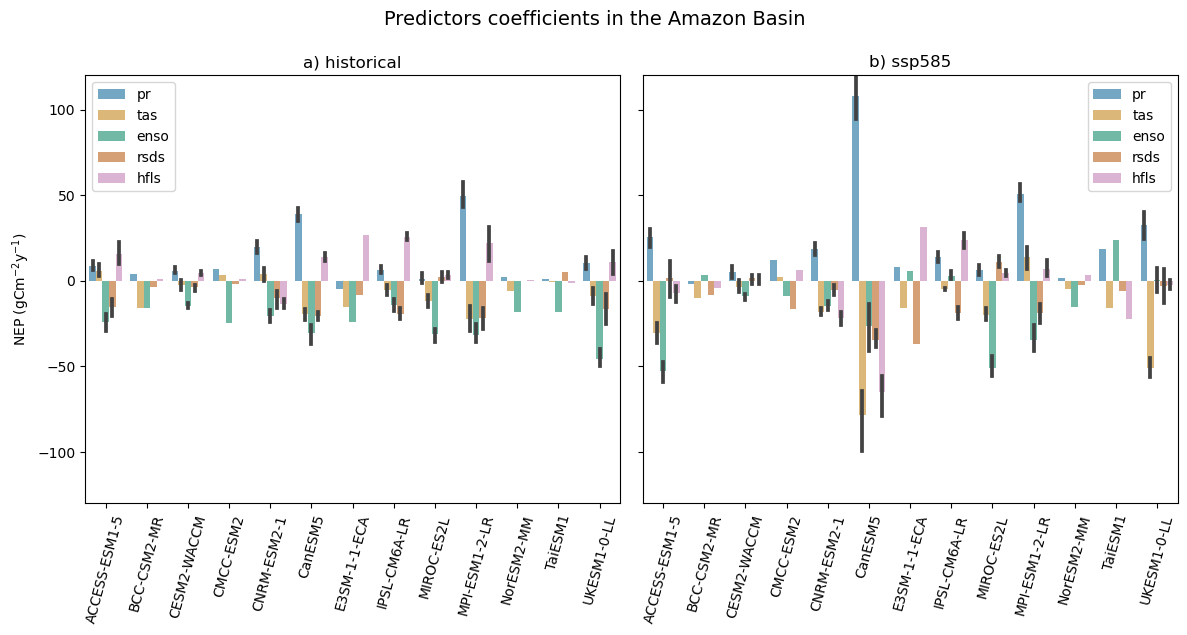

In [71]:
import seaborn as sns 

fig = plt.figure(figsize=(12, 6))

data = df[(df['effect'] != 'nep_pred') & (df['effect'] != 'nep')].copy()

# Plot annual mean zonal values in the Amazon basin of each model
ax0 = fig.add_subplot(121)
ax0 = sns.barplot(
    data=data[data['scenario'] == 'hist'].rename(columns={'effect': 'variable'}), hue="variable",# errorbar=("pi", 50),
    x="esm", y="value",
    palette='colorblind', alpha=.6, 
)
ax0.set_ylim(-130, 120)
ax0.set_xticklabels(sorted(list(set(esm))) , rotation = 75)
ax0.legend(loc='upper left', fontsize = 10)
ax0.set_xlabel("")
ax0.set_ylabel("NEP (gCm$^{-2}$y$^{-1}$)")
ax0.set_title("a) historical")

ax1 = fig.add_subplot(122)
ax1 = sns.barplot(
    data=data[data['scenario'] == 'ssp'].rename(columns={'effect': 'variable'}), hue="variable", # errorbar=("pi", 50),
    x="esm", y="value",
    palette='colorblind', alpha=.6, 
)
ax1.set_ylim(-130, 120)
ax1.set_xticklabels(sorted(list(set(esm))) , rotation = 75)
ax1.set_yticklabels("")
ax1.legend()
ax1.set_ylabel("")
ax1.set_xlabel("")
ax1.set_title("b) ssp585")

fig.tight_layout()
title = 'Predictors coefficients in the Amazon Basin'
fig.suptitle(title, y = 1.05, fontsize = 14)
# output_file = os.path.join(out_path, title) + "_c.png"


# g = sns.catplot(
#     data=df[(df['effect'] != 'nep_pred') & (df['effect'] != 'nep')], kind="bar", col = "scenario",# errorbar=("pi", 50),
#     x="esm", y="value", hue="effect",
#     palette='colorblind', alpha=.6, height=6
# )

# # g.despine(left=True)
# title = 'Predictors coefficients in the Amazon Basin'
# g.fig.suptitle(title, y = 1.05)
# g.set_xticklabels(rotation = 75)
# g.set_axis_labels("", "NEP (gCm$^{-2}$y$^{-1}$)")
# g.set_titles("a) historical", "b) ssp585")
# g.fig.set_figwidth(12,8)
# output_file = os.path.join(out_path, title) + ".png"
# plt.savefig(output_file, bbox_inches='tight')

In [57]:
df.to_csv(os.path.join(out_path,"df_coeff_mlr_lag.csv"))

In [100]:
df_mlr = pd.read_csv(os.path.join(out_path,"df_coeff_mlr.csv")).drop(columns = "Unnamed: 0")
df_mlr = df_mlr[df_mlr['effect'] == 'enso']
df = df[df['effect'] == 'enso']
df.effect = "enso_lag"

In [114]:
lag_effect = pd.concat([df,df_mlr], axis = 0)

In [115]:
lag_effect

,esm,effect,value,scenario
172,ACCESS-ESM1-5,enso_lag,-20.409593,hist
173,ACCESS-ESM1-5,enso_lag,-16.103871,hist
174,ACCESS-ESM1-5,enso_lag,-24.347944,hist
175,ACCESS-ESM1-5,enso_lag,-27.276645,hist
176,ACCESS-ESM1-5,enso_lag,-32.492312,hist
...,...,...,...,...
511,UKESM1-0-LL,enso,-112.972539,ssp
512,UKESM1-0-LL,enso,-108.886752,ssp
513,UKESM1-0-LL,enso,-129.673656,ssp
514,UKESM1-0-LL,enso,-89.860892,ssp


Text(0.5, 1.05, 'Predictors coefficients in the Amazon Basin')

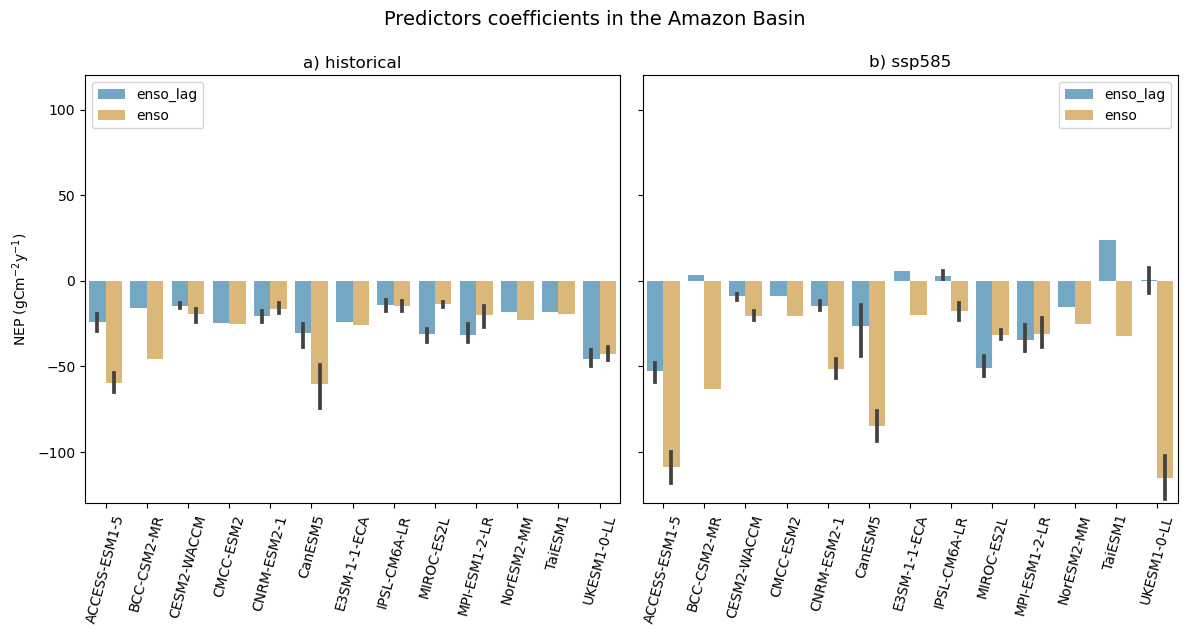

In [116]:
import seaborn as sns 

fig = plt.figure(figsize=(12, 6))

data = lag_effect.copy()

# Plot annual mean zonal values in the Amazon basin of each model
ax0 = fig.add_subplot(121)
ax0 = sns.barplot(
    data=data[data['scenario'] == 'hist'].rename(columns={'effect': 'variable'}), hue="variable",# errorbar=("pi", 50),
    x="esm", y="value",
    palette='colorblind', alpha=.6, 
)
ax0.set_ylim(-130, 120)
ax0.set_xticklabels(sorted(list(set(esm))) , rotation = 75)
ax0.legend(loc='upper left', fontsize = 10)
ax0.set_xlabel("")
ax0.set_ylabel("NEP (gCm$^{-2}$y$^{-1}$)")
ax0.set_title("a) historical")

ax1 = fig.add_subplot(122)
ax1 = sns.barplot(
    data=data[data['scenario'] == 'ssp'].rename(columns={'effect': 'variable'}), hue="variable", # errorbar=("pi", 50),
    x="esm", y="value",
    palette='colorblind', alpha=.6, 
)
ax1.set_ylim(-130, 120)
ax1.set_xticklabels(sorted(list(set(esm))) , rotation = 75)
ax1.set_yticklabels("")
ax1.legend()
ax1.set_ylabel("")
ax1.set_xlabel("")
ax1.set_title("b) ssp585")

fig.tight_layout()
title = 'Predictors coefficients in the Amazon Basin'
fig.suptitle(title, y = 1.05, fontsize = 14)
# output_file = os.path.join(out_path, title) + "_c.png"

